# Stock Exchange Price Forecasting


## Import Libraries


In [271]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from warnings import filterwarnings

# Avoid showing warnings to keep the notebook outputs clean.
filterwarnings("ignore")


## Data Cleaning

### Load the Data

In [250]:
# Load the stock data and check whether it has been loaded correctly.
data = pd.read_csv(
    "data/index_data.csv",
    on_bad_lines="error",
)
print("Data Info Overview:")
data.info()


Data Info Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112457 entries, 0 to 112456
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Index      112457 non-null  object 
 1   Date       112457 non-null  object 
 2   Open       110253 non-null  float64
 3   High       110253 non-null  float64
 4   Low        110253 non-null  float64
 5   Close      110253 non-null  float64
 6   Adj Close  110253 non-null  float64
 7   Volume     110253 non-null  float64
dtypes: float64(6), object(2)
memory usage: 6.9+ MB


### Convert Date Column to Datetime

In [251]:
data["Date"] = pd.to_datetime(data["Date"])
print("Data Info Overview After Date Type Conversion:")
data.info()

Data Info Overview After Date Type Conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112457 entries, 0 to 112456
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Index      112457 non-null  object        
 1   Date       112457 non-null  datetime64[ns]
 2   Open       110253 non-null  float64       
 3   High       110253 non-null  float64       
 4   Low        110253 non-null  float64       
 5   Close      110253 non-null  float64       
 6   Adj Close  110253 non-null  float64       
 7   Volume     110253 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 6.9+ MB


### Remove Incomplete Rows

In [252]:
# Count how many missing values are in each column.
print("Number of Missing Values Per Column:")
display(data.isnull().sum())

# Remove rows with missing values.
data.dropna(axis=0, how="any", inplace=True)

# Check that the missing values have been removed.
print("Number of Missing Values Per Column After Cleaning:")
display(data.isnull().sum())

Number of Missing Values Per Column:


Index           0
Date            0
Open         2204
High         2204
Low          2204
Close        2204
Adj Close    2204
Volume       2204
dtype: int64

Number of Missing Values Per Column After Cleaning:


Index        0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

#### Remove Days with Missing Volume

In [253]:
print(f"Number of Records Before Excluding Days with Missing Volume: {len(data)}")
data = data.loc[data["Volume"] != 0]
print(f"Number of Records After Excluding Days with Missing Volume: {len(data)}")


Number of Records Before Excluding Days with Missing Volume: 110253
Number of Records After Excluding Days with Missing Volume: 68160


## Data Exploration


### Calculate Distribution of Features

In [254]:
data.describe()

Open          High           Low         Close     Adj Close  \
count  68160.000000  68160.000000  68160.000000  68160.000000  68160.000000   
mean    7649.330078   7695.840563   7596.432307   7648.235456   7648.026040   
std     6174.152000   6208.194030   6133.361275   6171.872267   6172.011375   
min      238.000000    238.399994    237.699997    238.100006    238.100006   
25%     2403.092407   2418.807434   2384.533264   2403.179931   2403.104919   
50%     6843.819824   6886.599853   6788.415039   6838.425049   6838.412110   
75%    10769.785160  10825.682372  10705.840085  10768.712400  10768.682370   
max    33335.480470  33484.078130  32897.039060  33154.121090  33154.121090   

             Volume  
count  6.816000e+04  
mean   2.060733e+09  
std    5.339244e+09  
min    1.000000e+02  
25%    1.785225e+06  
50%    1.027414e+08  
75%    1.559118e+09  
max    9.440374e+10

### Explore the Index Information

In [255]:
# Load the index info to understand what each index ticker represents.
index_info = pd.read_csv(
    "data/index_info.csv",
    on_bad_lines="error",
)
display(index_info)


Region                          Exchange      Index Currency
0   United States           New York Stock Exchange        NYA      USD
1   United States                            NASDAQ       IXIC      USD
2       Hong Kong          Hong Kong Stock Exchange        HSI      HKD
3           China           Shanghai Stock Exchange  000001.SS      CNY
4           Japan              Tokyo Stock Exchange       N225      JPY
5          Europe                          Euronext       N100      EUR
6           China           Shenzhen Stock Exchange  399001.SZ      CNY
7          Canada            Toronto Stock Exchange     GSPTSE      CAD
8           India  National Stock Exchange of India       NSEI      INR
9         Germany          Frankfurt Stock Exchange      GDAXI      EUR
10          Korea                    Korea Exchange       KS11      KRW
11    Switzerland                SIX Swiss Exchange       SSMI      CHF
12         Taiwan             Taiwan Stock Exchange       TWII      TWD
13   South Africa       Johannesburg Stock Exchange    J203.JO      ZAR

### Split the Data by Index


In [256]:
# Split the data set by 'Index' column.
data_frames_per_index = {
    key: data.loc[value] for key, value in data.groupby("Index").groups.items()
}

# Show how many rows of data are available for each index.
print("Sample Size Per Index:")
for index, data_frame in data_frames_per_index.items():
    print(f"{index}: {len(data_frame)}")

Sample Size Per Index:
000001.SS: 4430
399001.SZ: 4190
GDAXI: 5464
GSPTSE: 9183
HSI: 4890
IXIC: 9233
KS11: 6029
N100: 3817
N225: 4635
NSEI: 2026
NYA: 5115
SSMI: 4632
TWII: 4516


### Identify Feature Importance

In [257]:
# Show how each feature contributes to the target variable of adjusted close
# price for each index.
for index, data_frame in data_frames_per_index.items():
    print(f"Correlation of Features to Adjusted Close Price for {index}:")
    display(
        data_frame.corr(numeric_only=True)["Adj Close"].sort_values(ascending=False)
    )


Correlation of Features to Adjusted Close Price for 000001.SS:


Close        1.000000
Adj Close    1.000000
Low          0.999422
High         0.999406
Open         0.998855
Volume       0.336650
Name: Adj Close, dtype: float64

Correlation of Features to Adjusted Close Price for 399001.SZ:


Adj Close    1.000000
Close        1.000000
Low          0.999390
High         0.999358
Open         0.998701
Volume       0.393838
Name: Adj Close, dtype: float64

Correlation of Features to Adjusted Close Price for GDAXI:


Close        1.000000
Adj Close    1.000000
Low          0.999828
High         0.999803
Open         0.999611
Volume      -0.155977
Name: Adj Close, dtype: float64

Correlation of Features to Adjusted Close Price for GSPTSE:


Adj Close    1.000000
Close        1.000000
Low          0.999917
High         0.999906
Open         0.999856
Volume       0.825045
Name: Adj Close, dtype: float64

Correlation of Features to Adjusted Close Price for HSI:


Close        1.000000
Adj Close    1.000000
Low          0.999738
High         0.999710
Open         0.999399
Volume       0.613400
Name: Adj Close, dtype: float64

Correlation of Features to Adjusted Close Price for IXIC:


Close        1.000000
Adj Close    1.000000
Low          0.999934
High         0.999924
Open         0.999872
Volume       0.784782
Name: Adj Close, dtype: float64

Correlation of Features to Adjusted Close Price for KS11:


Close        1.000000
Adj Close    1.000000
Low          0.999880
High         0.999854
Open         0.999721
Volume       0.276762
Name: Adj Close, dtype: float64

Correlation of Features to Adjusted Close Price for N100:


Close        1.000000
Adj Close    1.000000
Low          0.999574
High         0.999465
Open         0.999004
Volume      -0.167245
Name: Adj Close, dtype: float64

Correlation of Features to Adjusted Close Price for N225:


Close        1.000000
Adj Close    1.000000
High         0.999790
Low          0.999784
Open         0.999583
Volume      -0.214087
Name: Adj Close, dtype: float64

Correlation of Features to Adjusted Close Price for NSEI:


Close        1.000000
Adj Close    1.000000
High         0.999656
Low          0.999625
Open         0.999278
Volume       0.599608
Name: Adj Close, dtype: float64

Correlation of Features to Adjusted Close Price for NYA:


Close        1.000000
Adj Close    1.000000
Low          0.999736
High         0.999673
Open         0.999408
Volume       0.301982
Name: Adj Close, dtype: float64

Correlation of Features to Adjusted Close Price for SSMI:


Close        1.000000
Adj Close    1.000000
Low          0.999638
High         0.999532
Open         0.999172
Volume      -0.010293
Name: Adj Close, dtype: float64

Correlation of Features to Adjusted Close Price for TWII:


Adj Close    1.000000
Close        1.000000
Low          0.999792
High         0.999717
Open         0.999462
Volume       0.034211
Name: Adj Close, dtype: float64

## Feature Engineering


### Calculate Simple Moving Averages


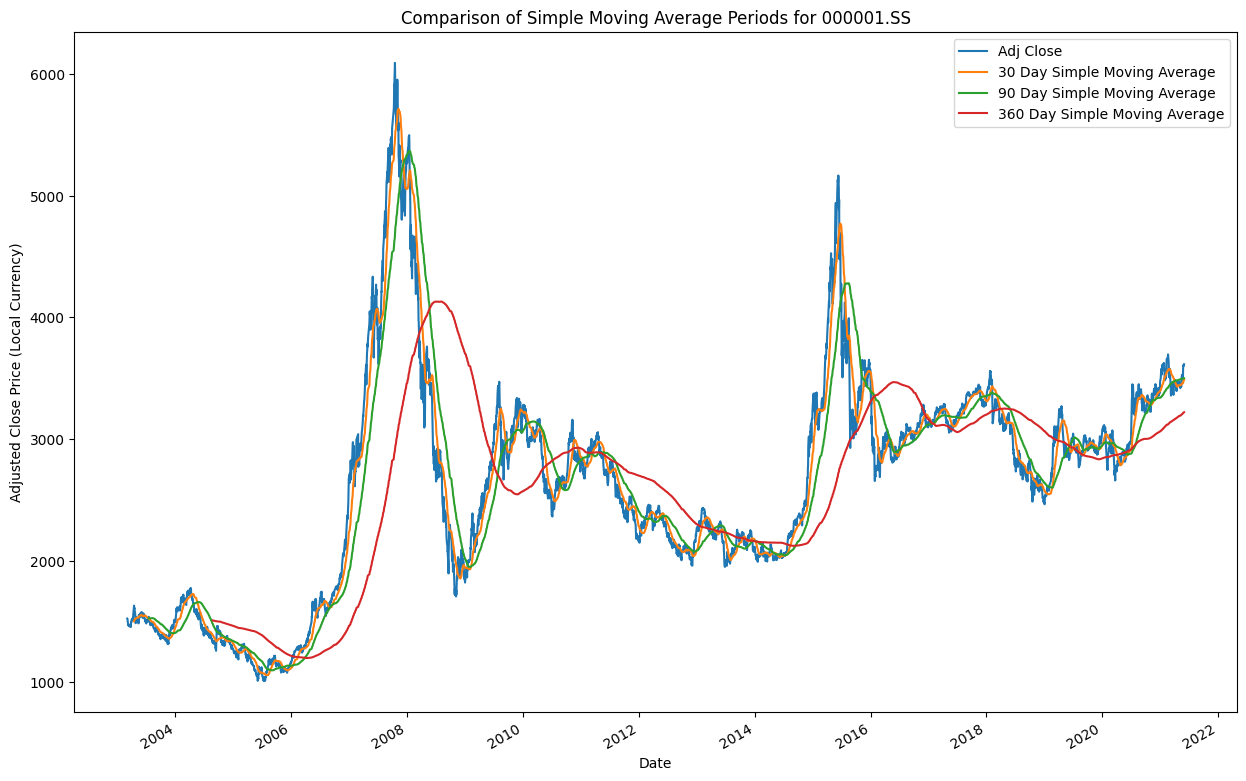

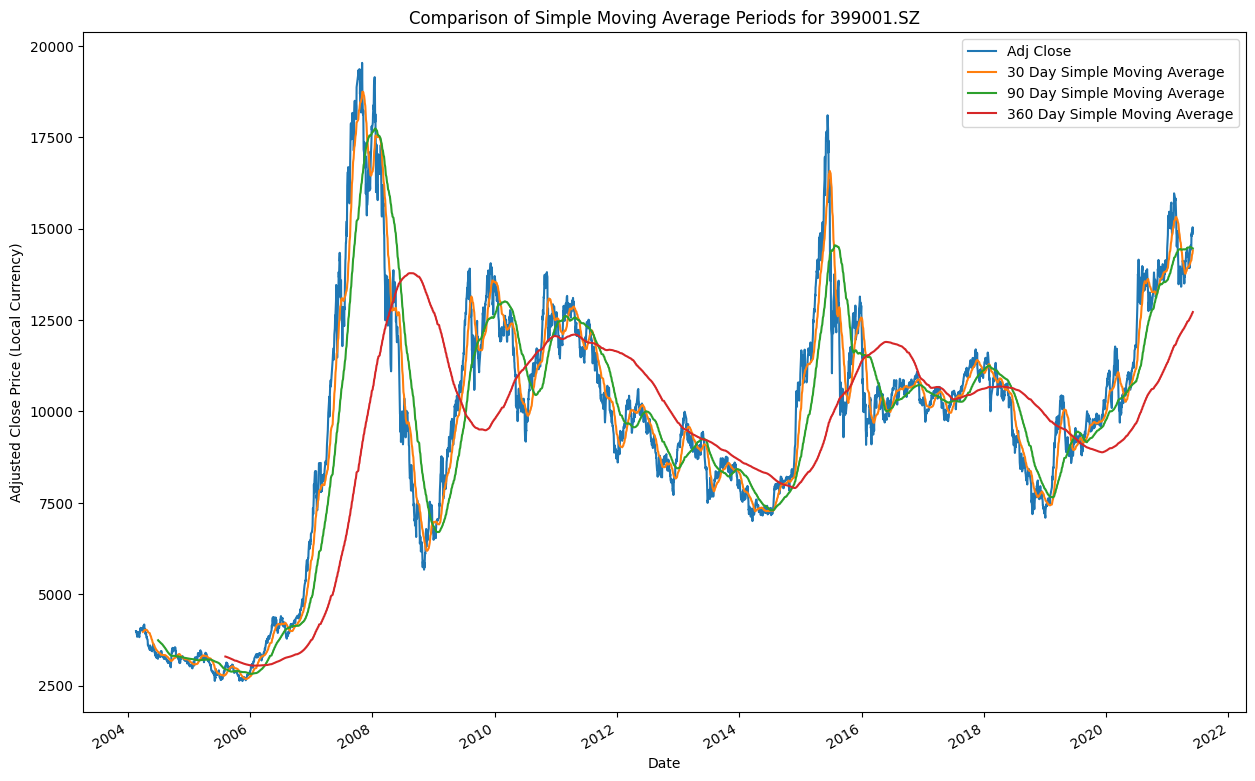

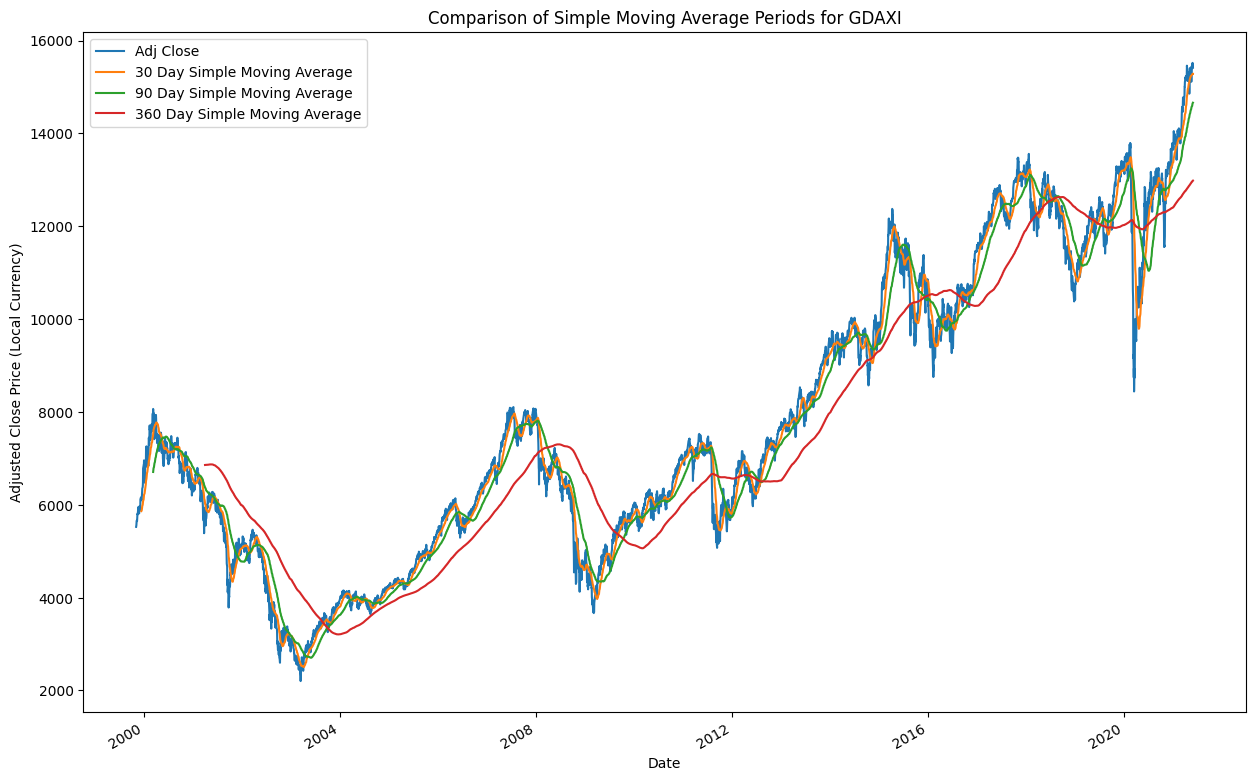

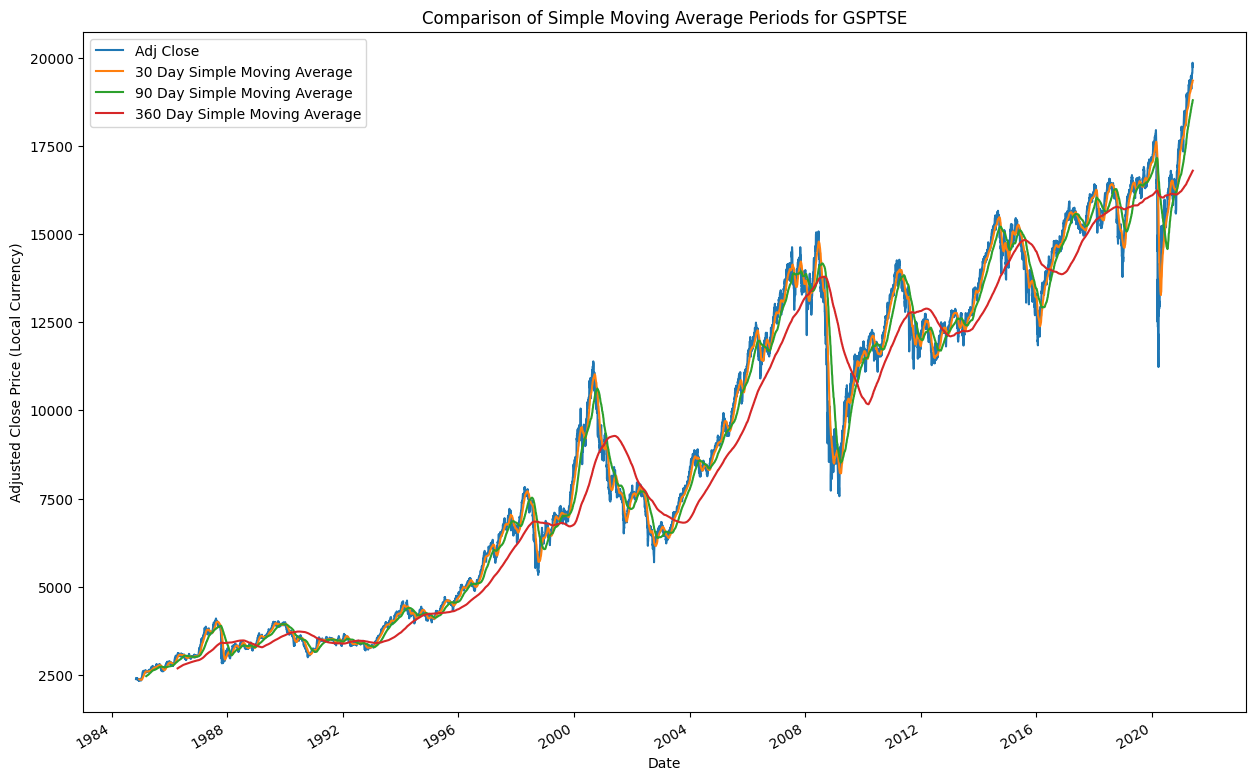

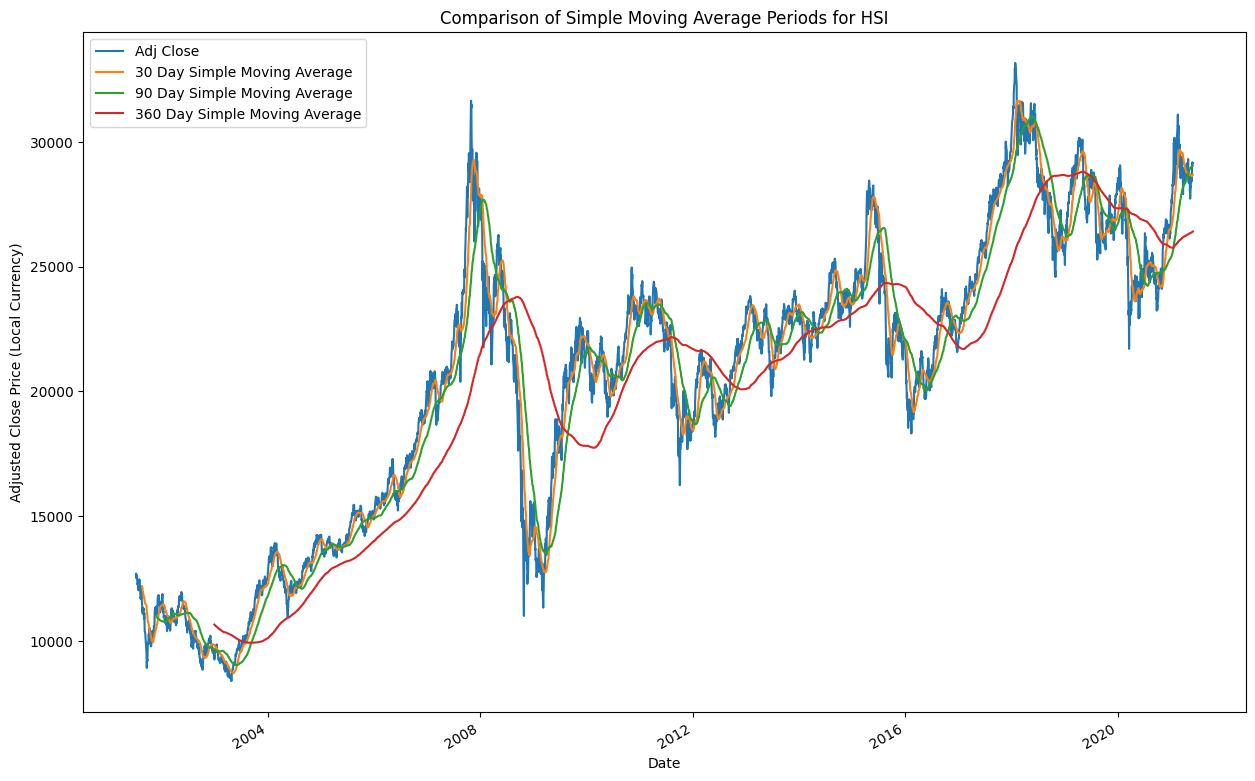

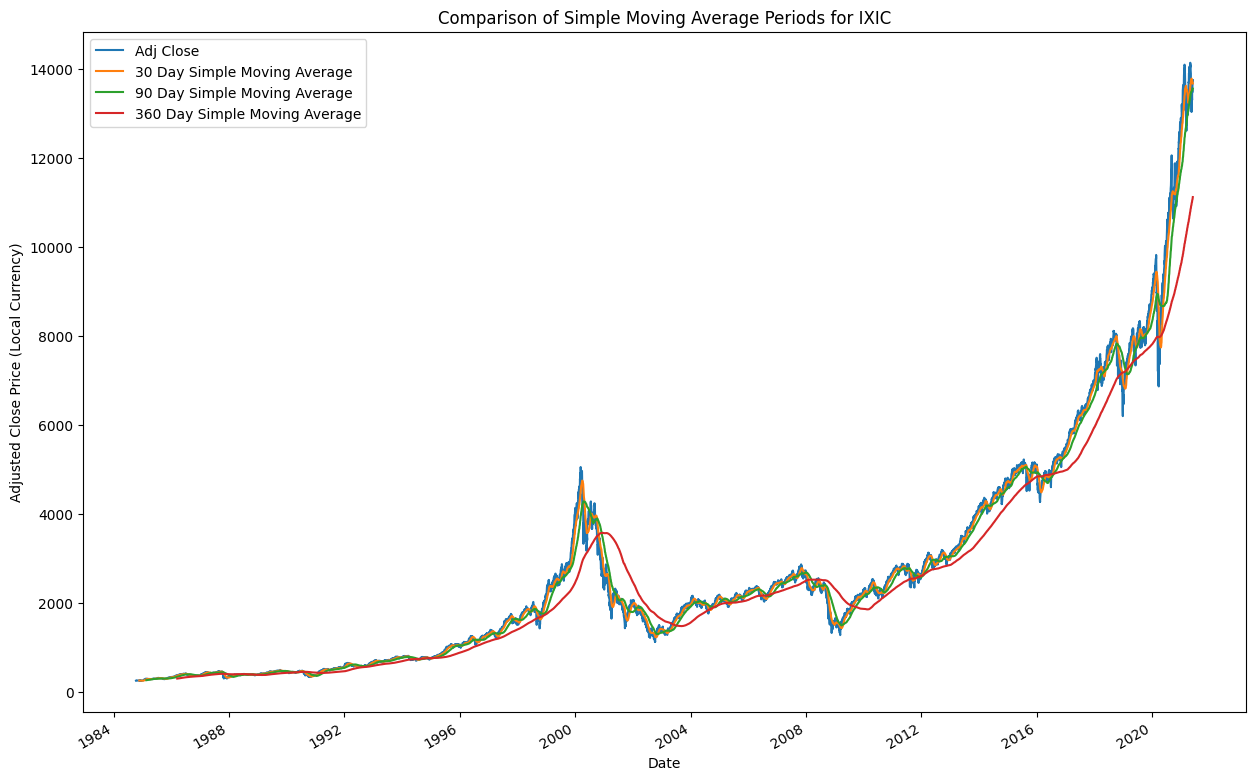

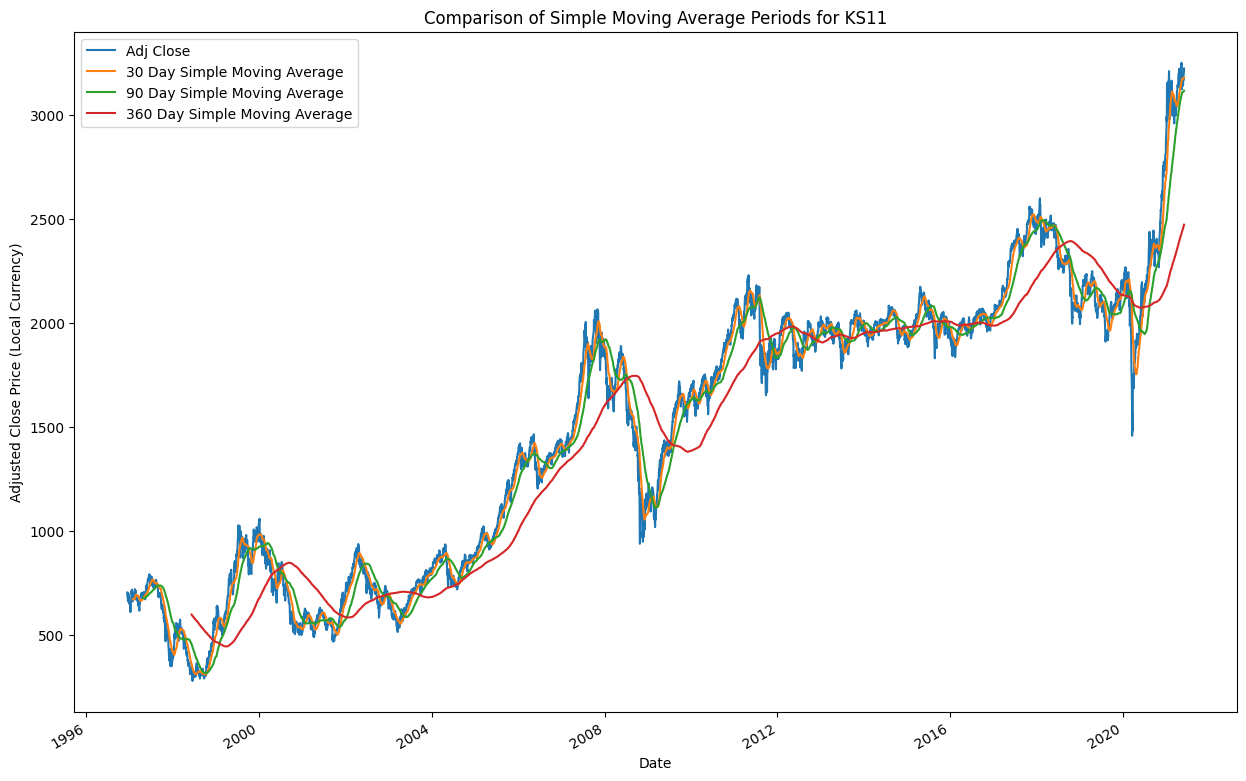

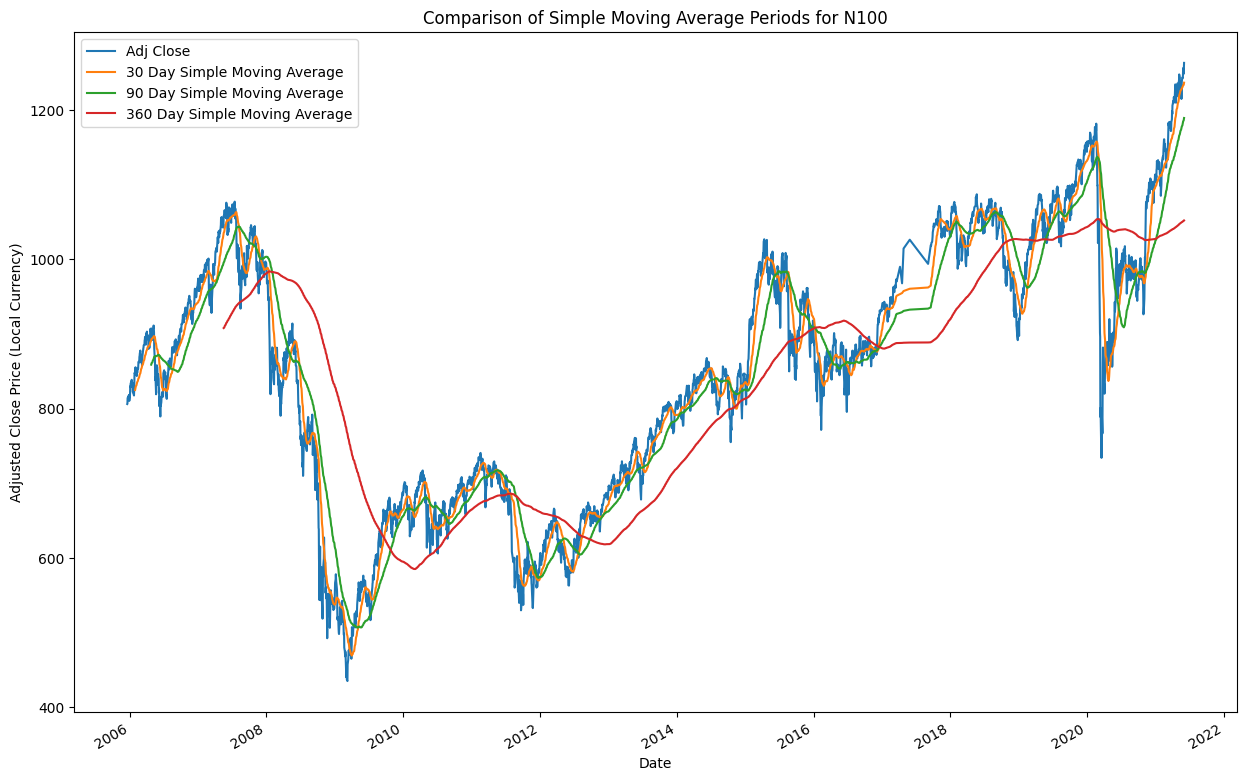

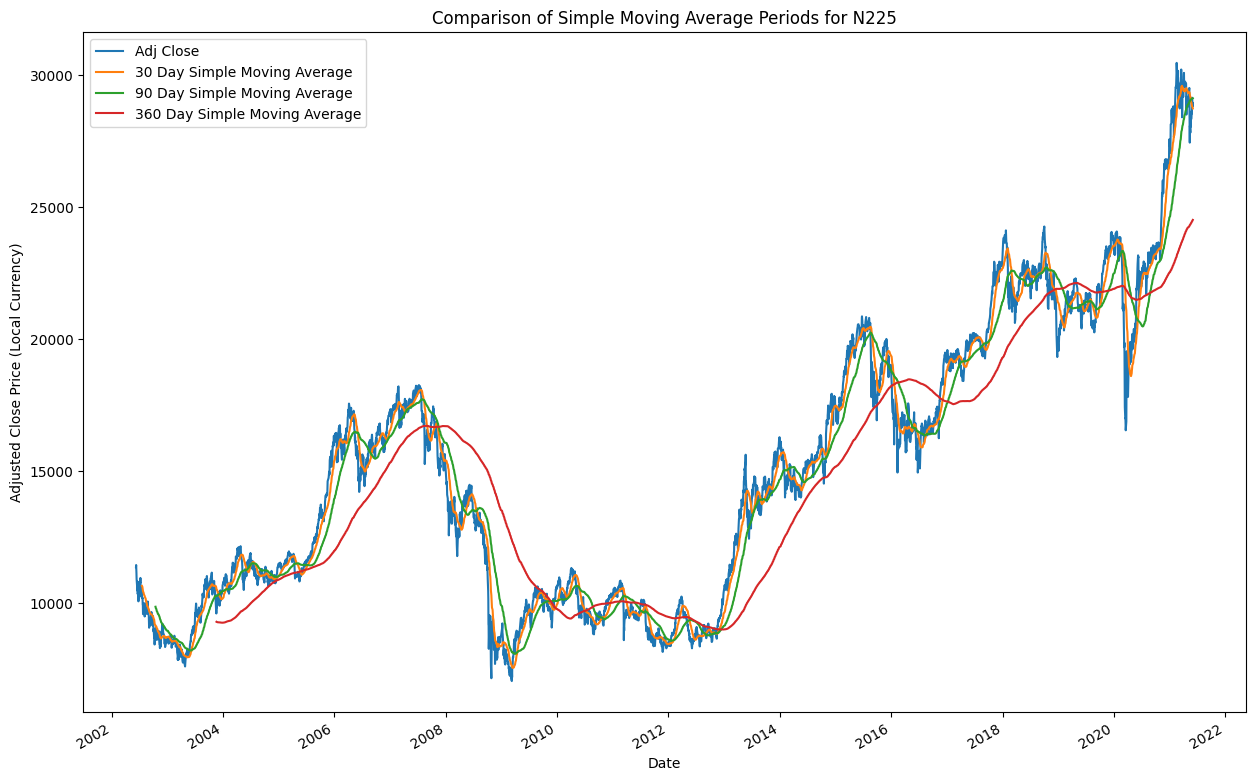

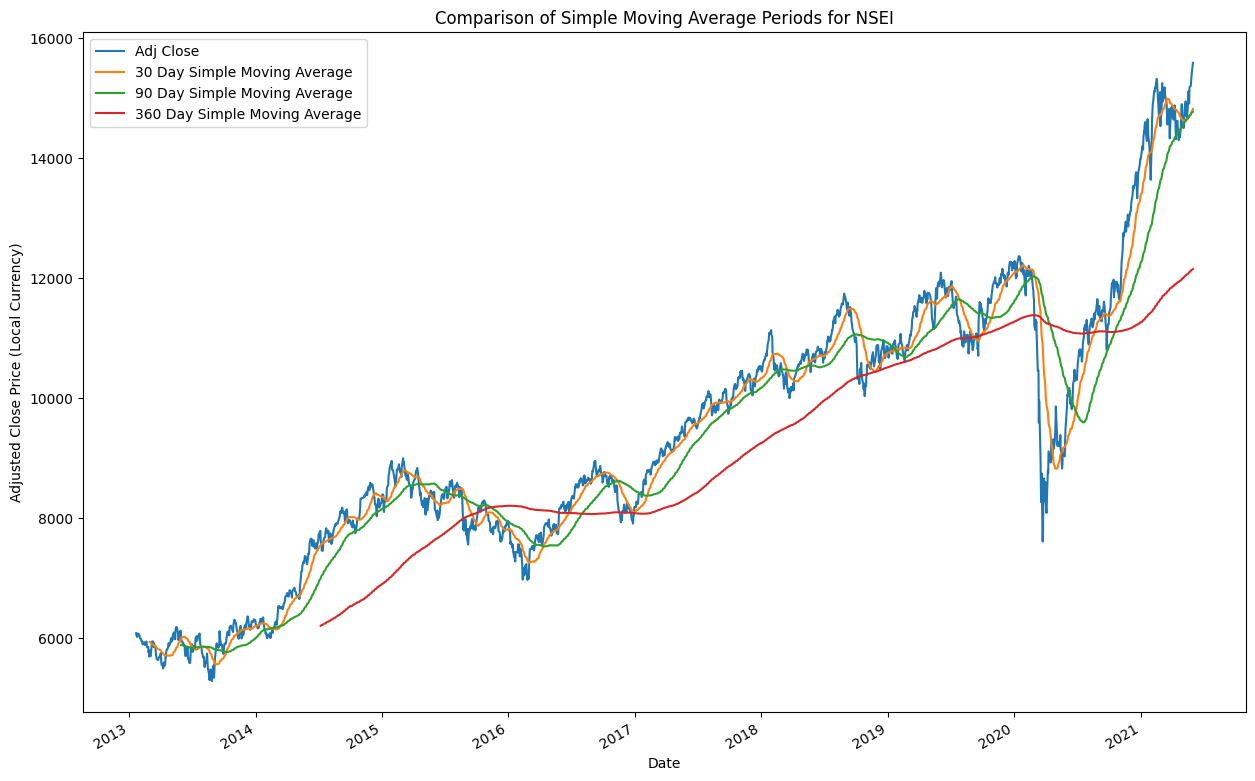

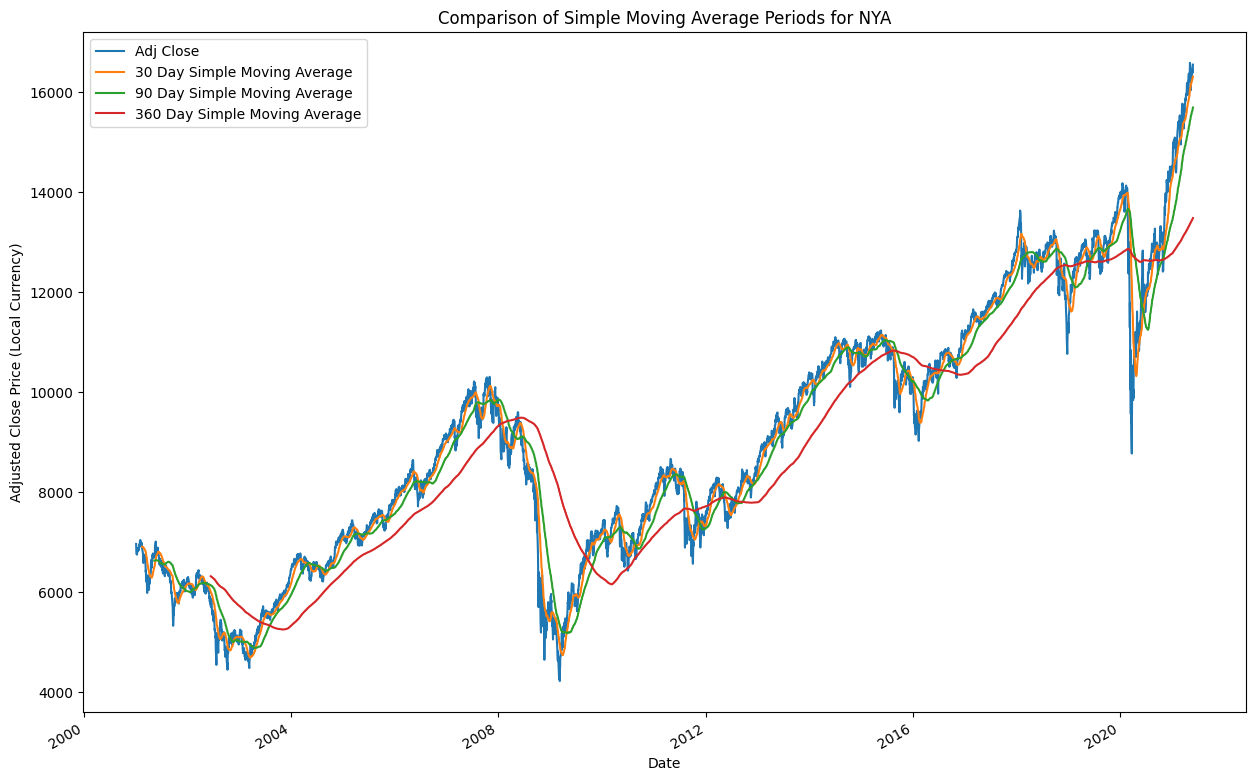

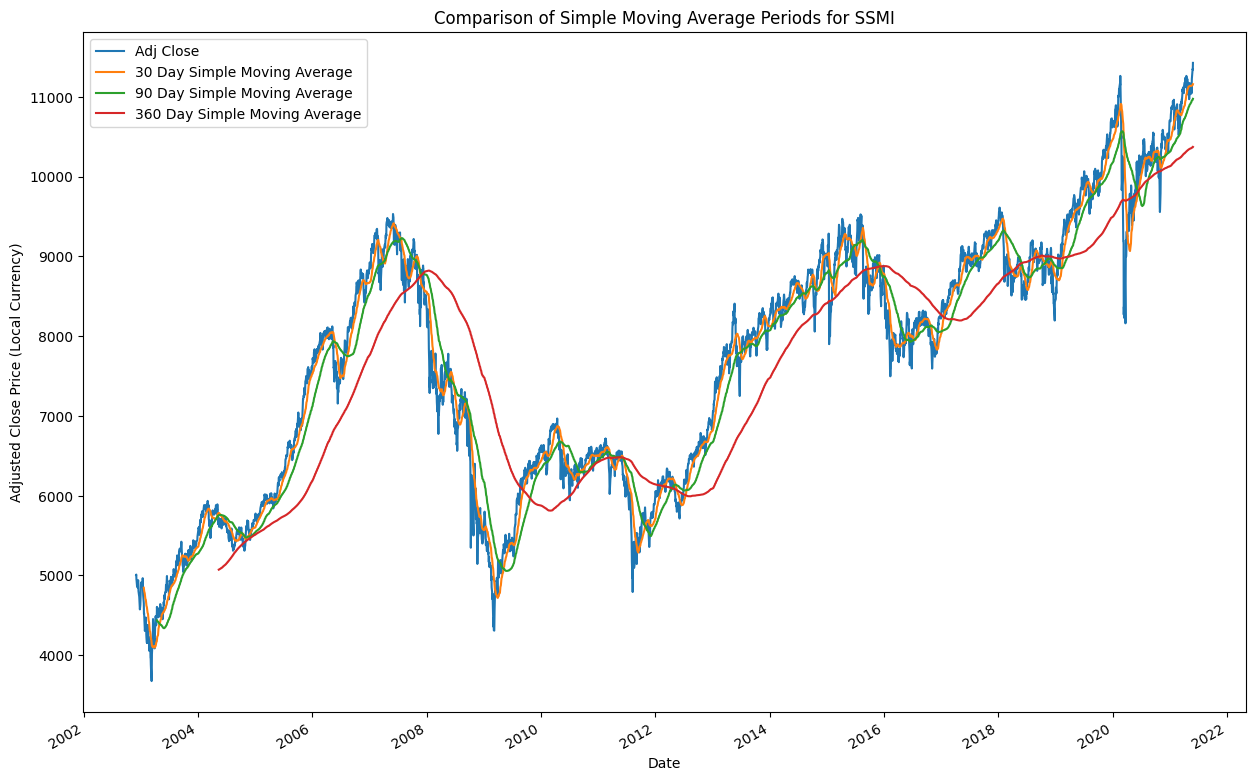

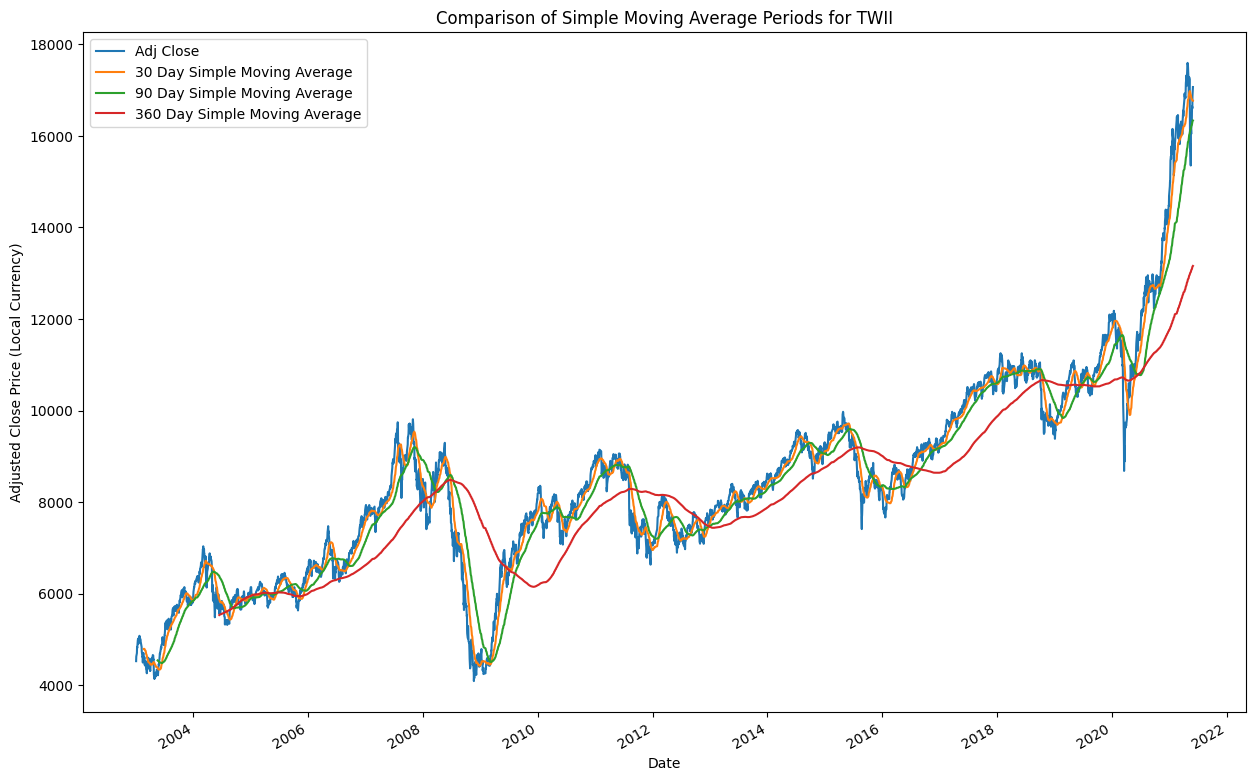

In [258]:
# Calculate simple moving averages for each index.
for index in data_frames_per_index.keys():
    # Increasing the window size smooths the data, but reduces the accuracy.
    data_frames_per_index[index]["30 Day Simple Moving Average"] = (
        data_frames_per_index[index]["Adj Close"].rolling(30, min_periods=30).mean()
    )
    data_frames_per_index[index]["90 Day Simple Moving Average"] = (
        data_frames_per_index[index]["Adj Close"].rolling(90, min_periods=90).mean()
    )
    data_frames_per_index[index]["360 Day Simple Moving Average"] = (
        data_frames_per_index[index]["Adj Close"].rolling(360, min_periods=360).mean()
    )

# Generate a time series graph for each index.
for index in data_frames_per_index.keys():
    data_frames_per_index[index].plot(
        x="Date",
        y=[
            "Adj Close",
            "30 Day Simple Moving Average",
            "90 Day Simple Moving Average",
            "360 Day Simple Moving Average",
        ],
        xlabel="Date",
        ylabel="Adjusted Close Price (Local Currency)",
        title=f"Comparison of Simple Moving Average Periods for {index}",
        figsize=(15, 10),
    )


### Calculate Exponential Moving Averages


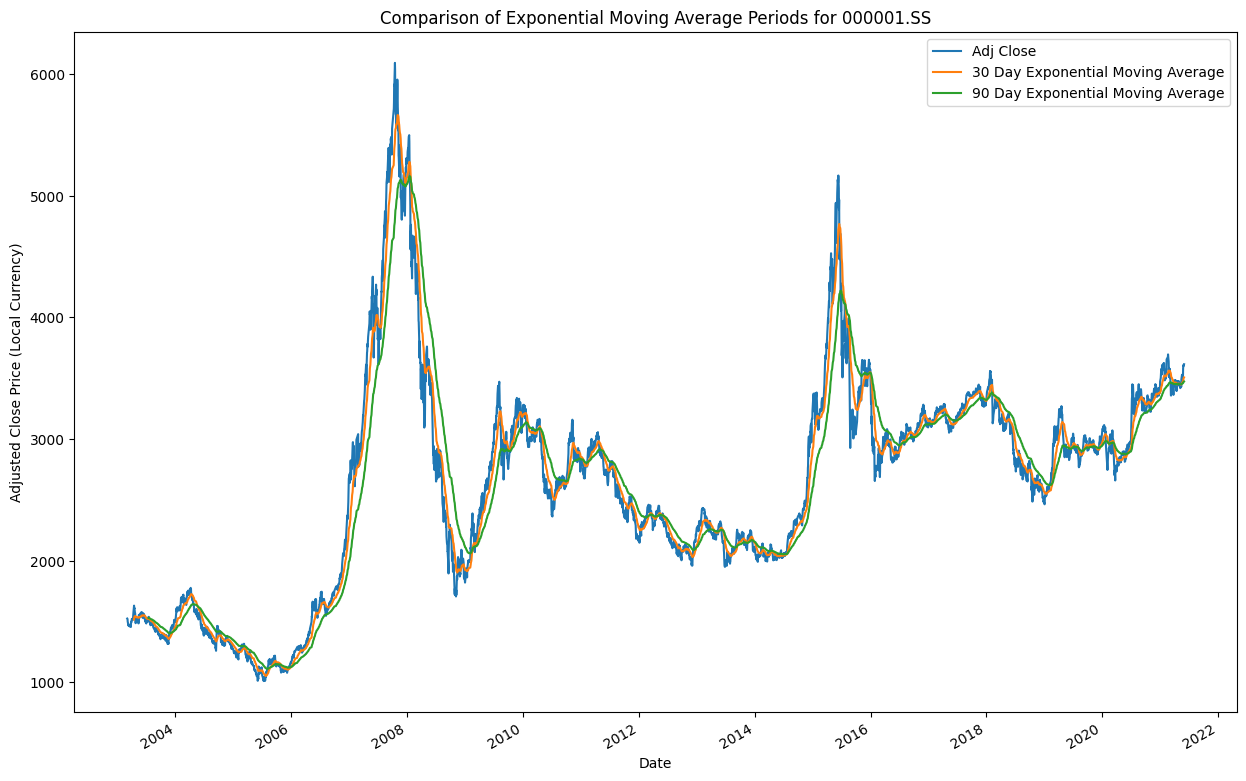

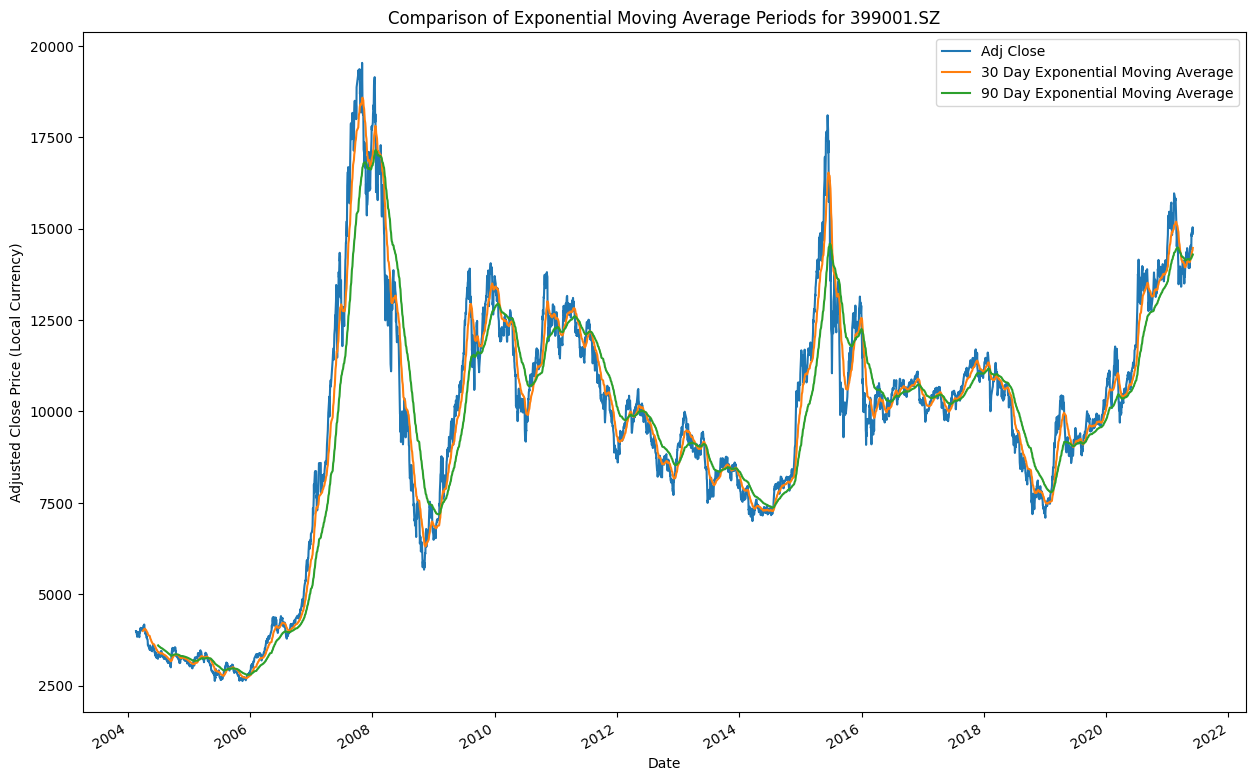

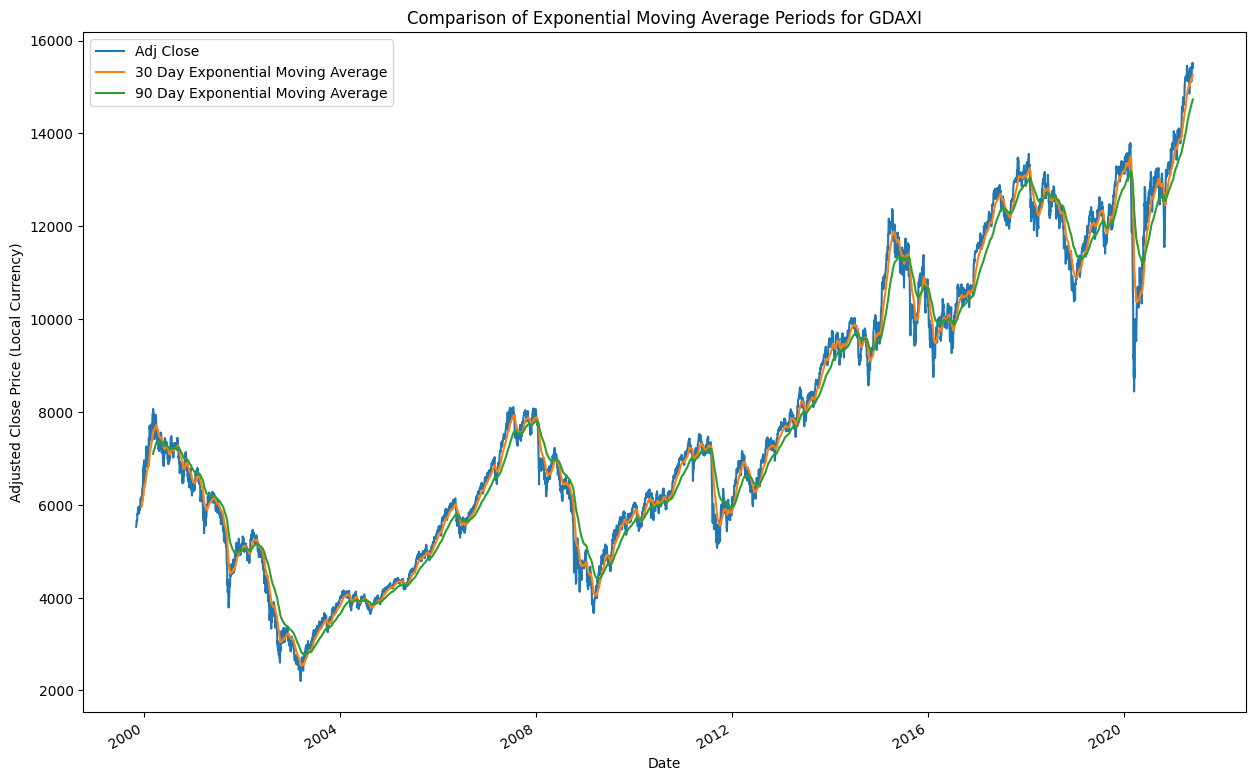

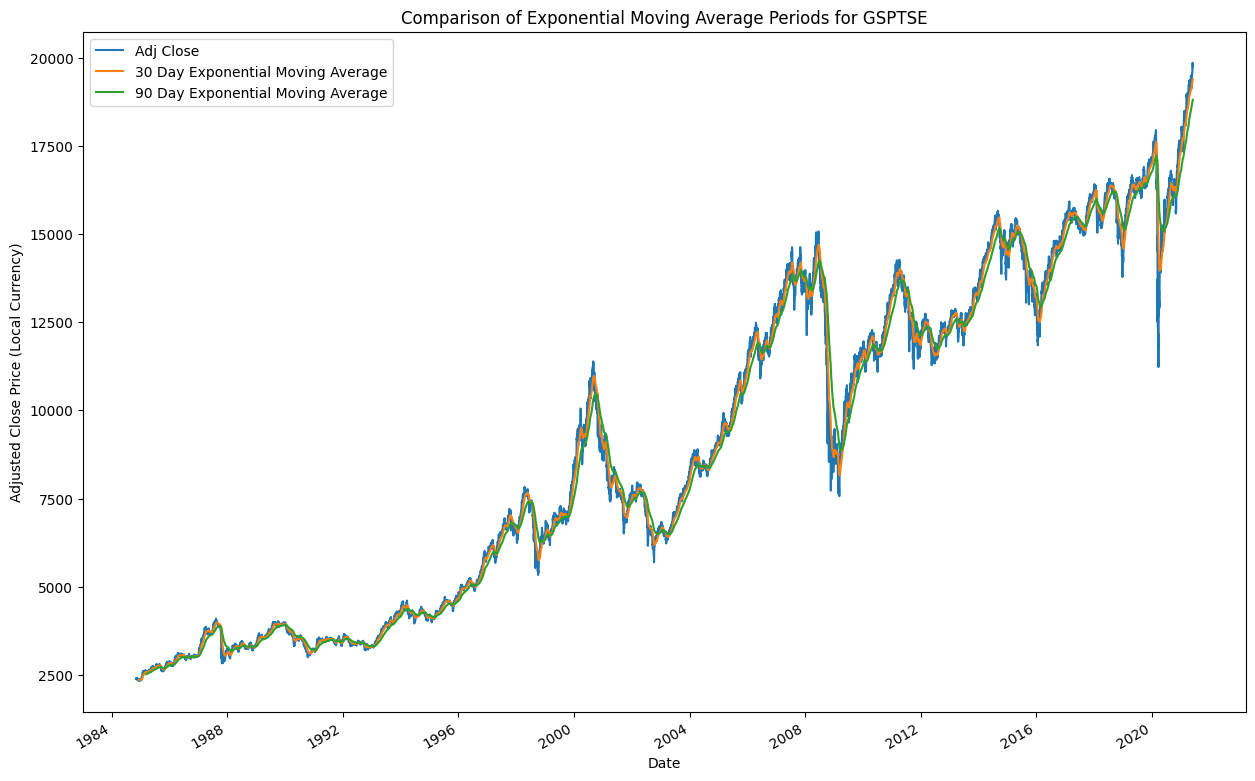

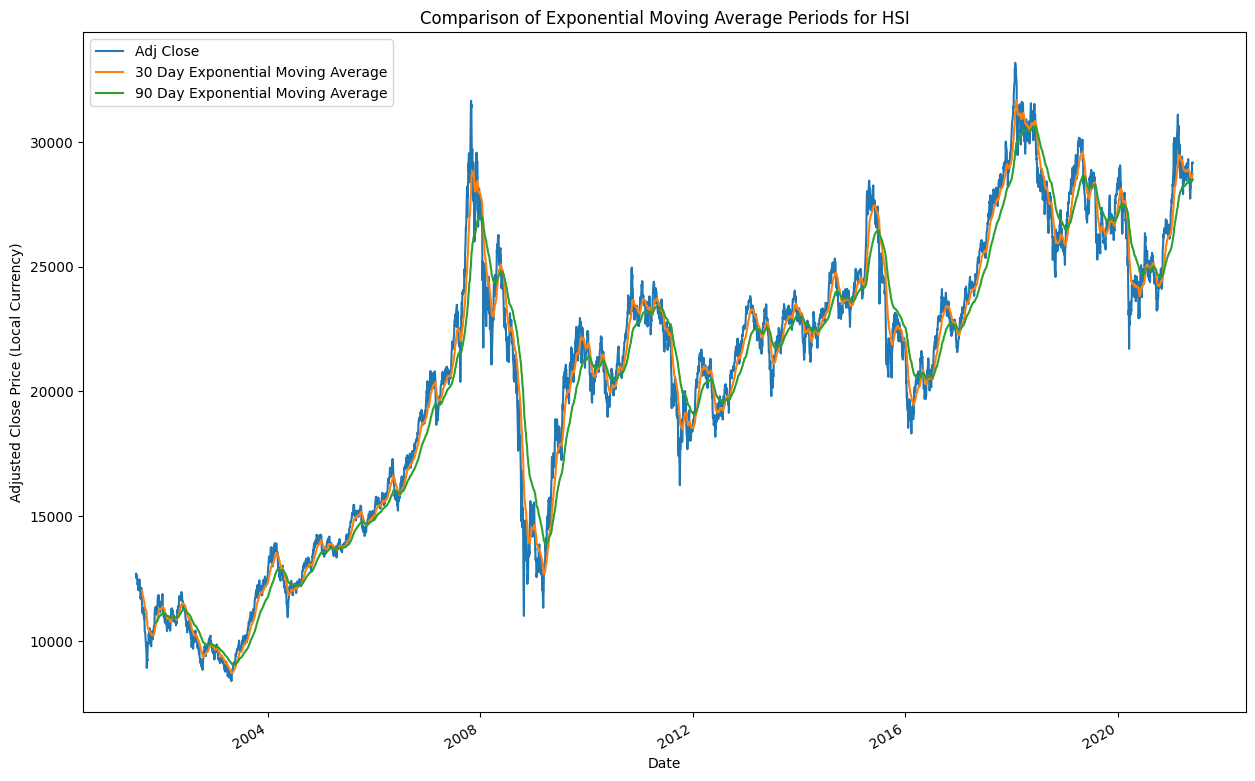

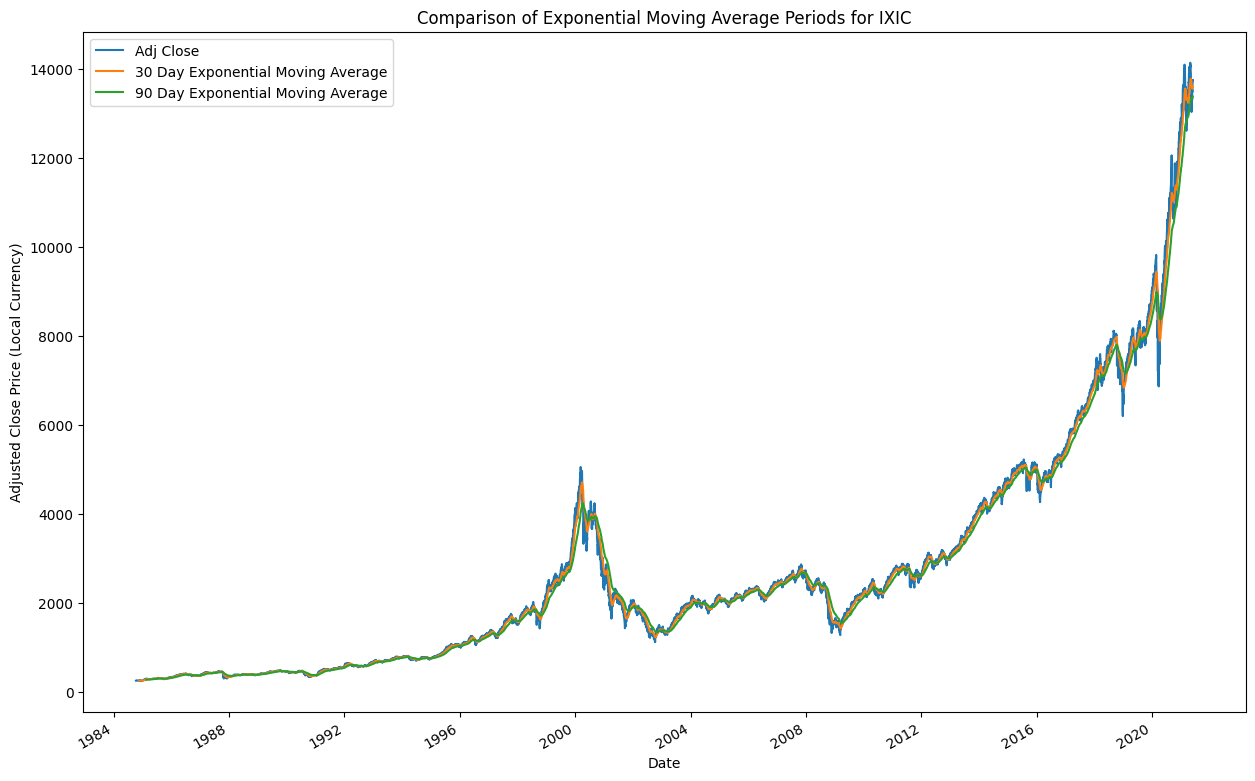

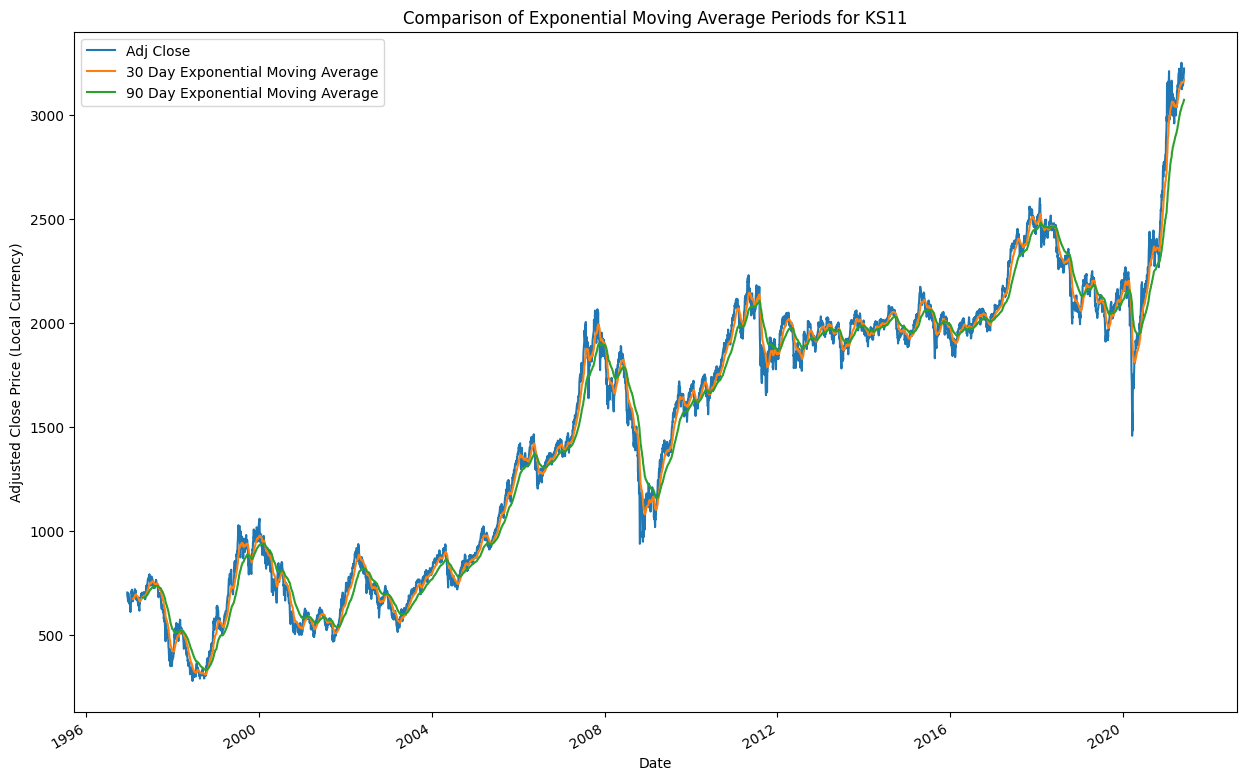

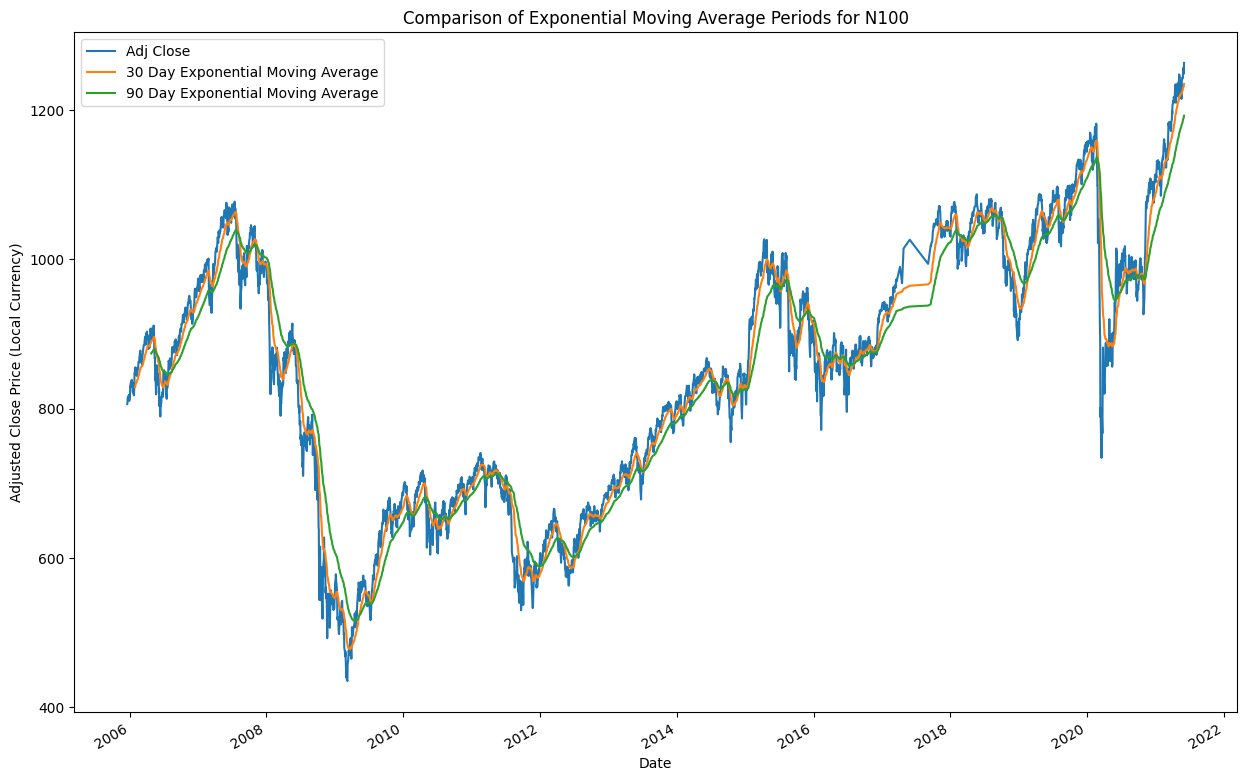

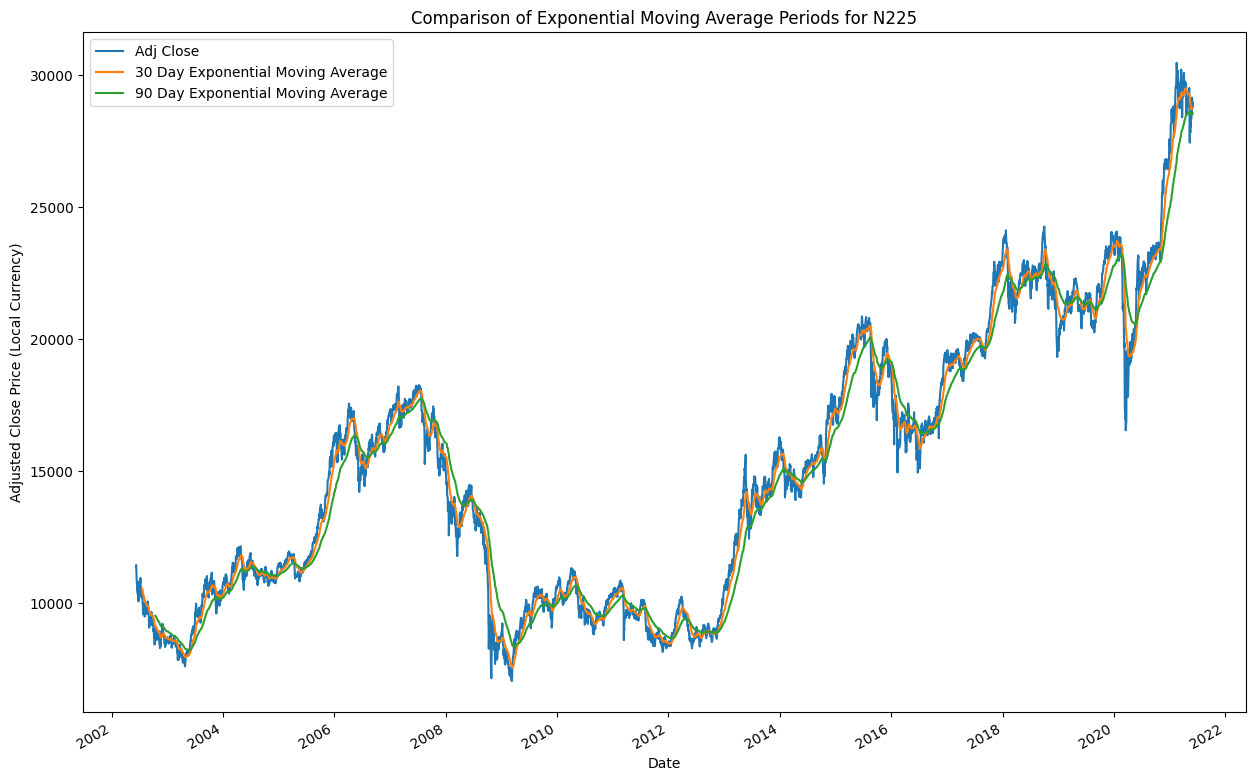

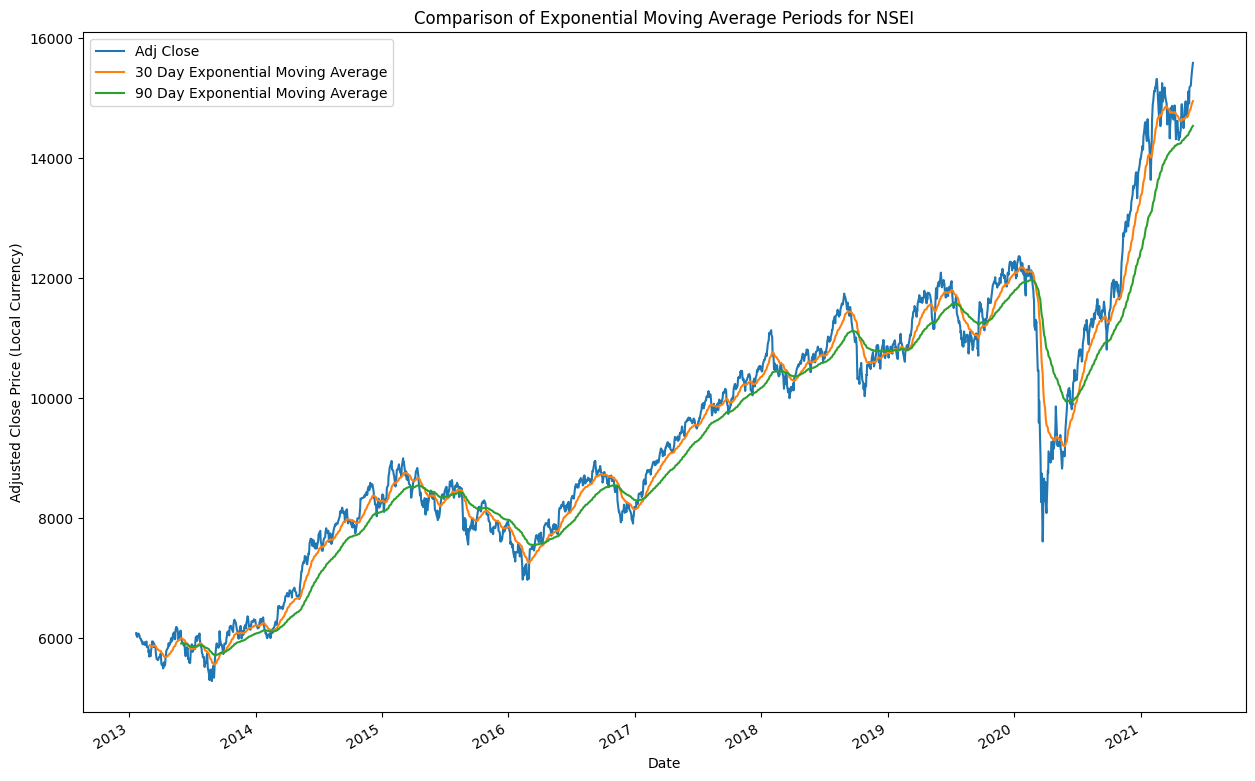

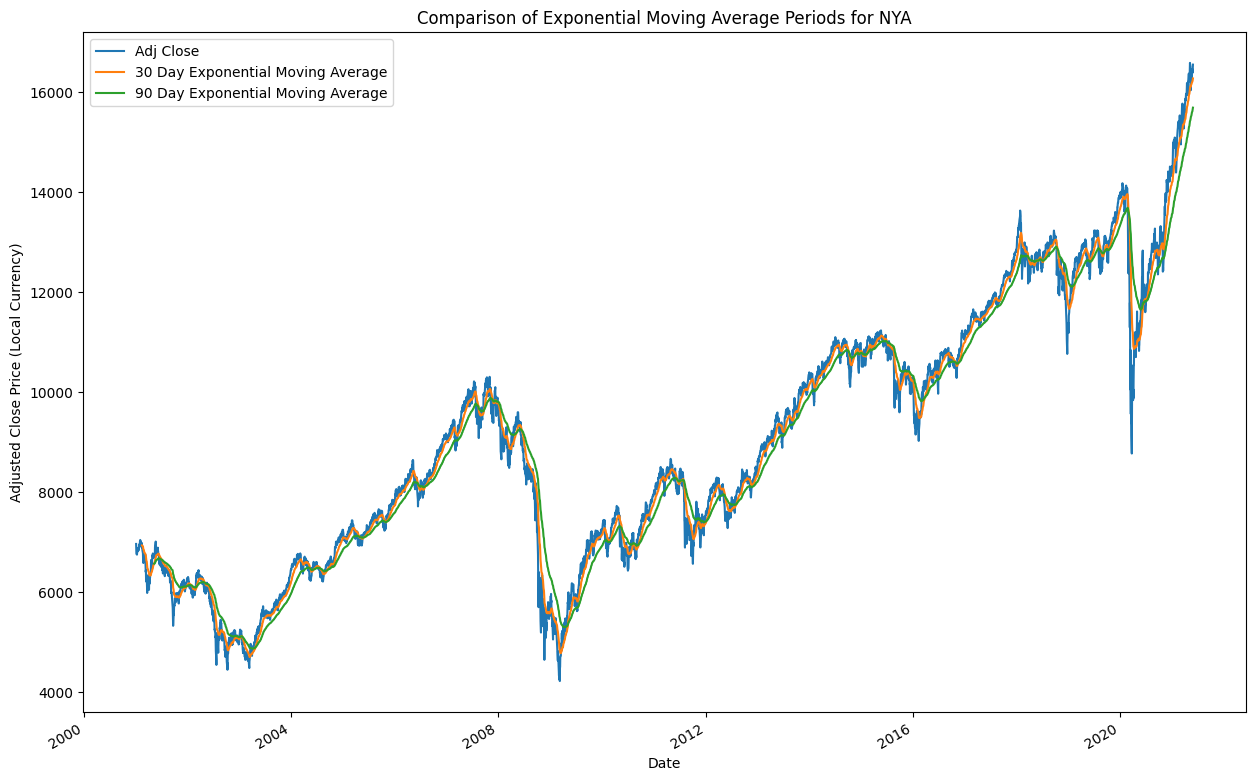

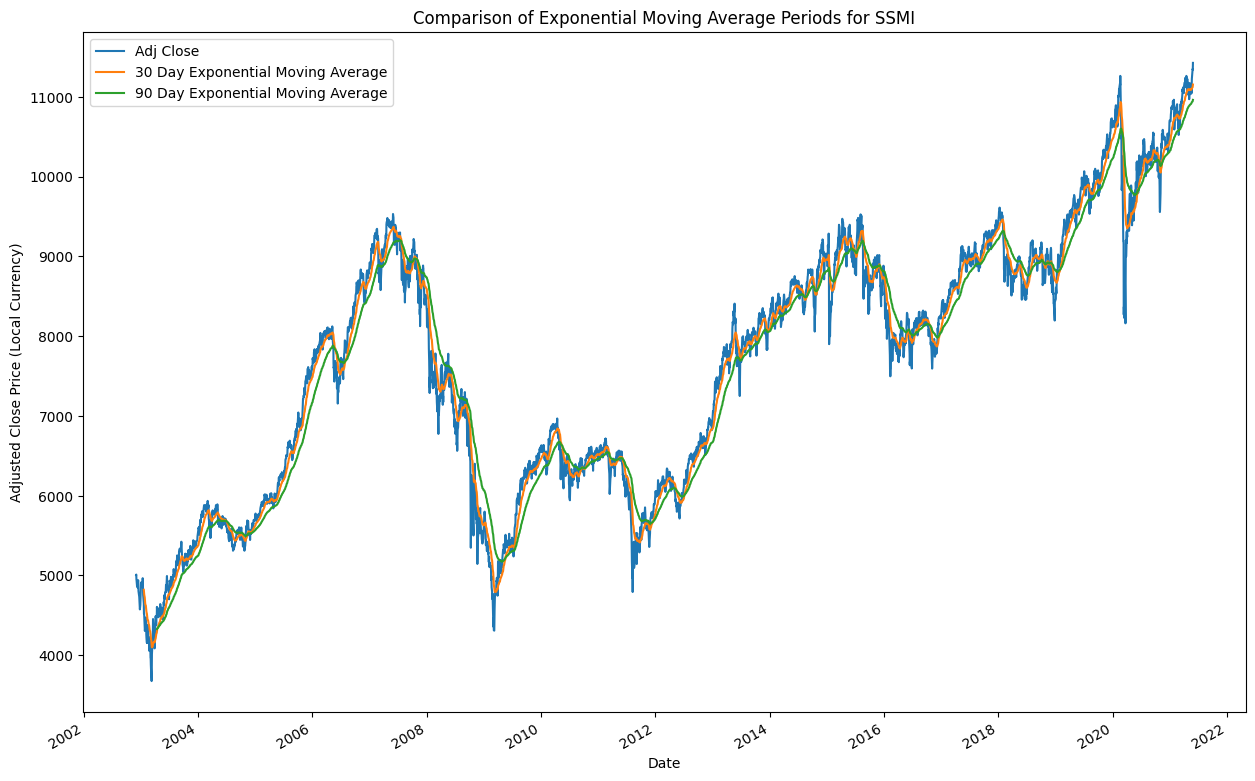

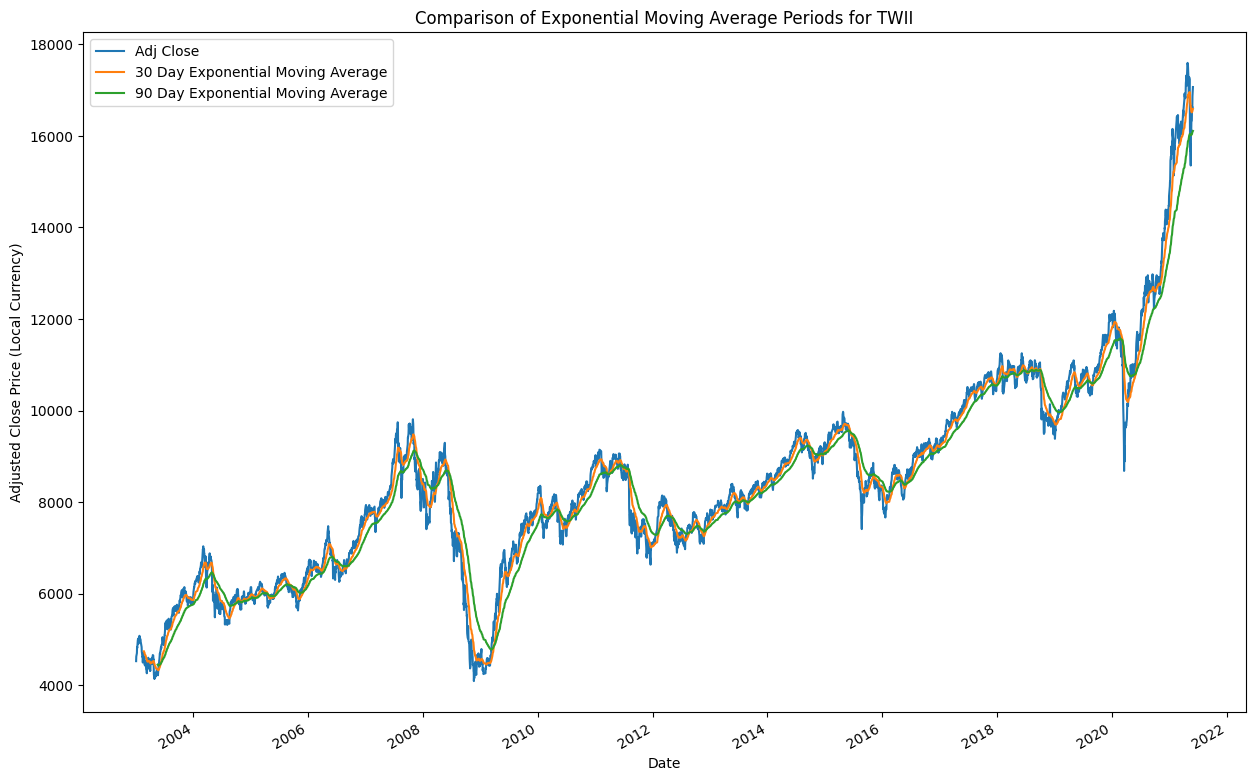

In [259]:
for index in data_frames_per_index.keys():
    # Calculate 30 and 90 day exponential moving averages for each index.
    data_frames_per_index[index]["30 Day Exponential Moving Average"] = (
        data_frames_per_index[index]["Adj Close"].ewm(span=30, min_periods=30).mean()
    )
    data_frames_per_index[index]["90 Day Exponential Moving Average"] = (
        data_frames_per_index[index]["Adj Close"].ewm(span=90, min_periods=90).mean()
    )

# Generate a time series graph for each index.
for index in data_frames_per_index.keys():
    data_frames_per_index[index].plot(
        x="Date",
        y=[
            "Adj Close",
            "30 Day Exponential Moving Average",
            "90 Day Exponential Moving Average",
        ],
        xlabel="Date",
        ylabel="Adjusted Close Price (Local Currency)",
        title=f"Comparison of Exponential Moving Average Periods for {index}",
        figsize=(15, 10),
    )


## Data Filtering


### Select Moving Average Strategy


<AxesSubplot: title={'center': 'Comparison of Moving Average Strategies for NASDAQ (IXIC) - Last 5 Years'}, xlabel='Date', ylabel='Adjusted Close Price (USD)'>

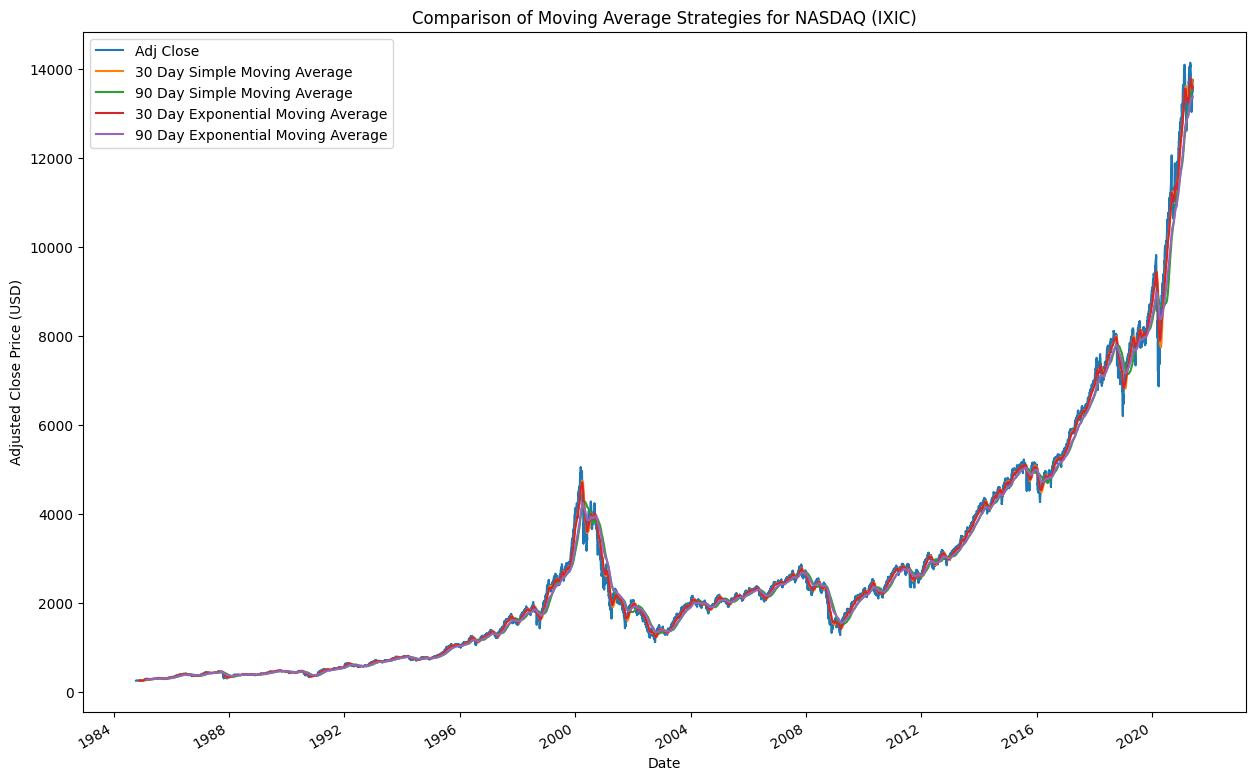

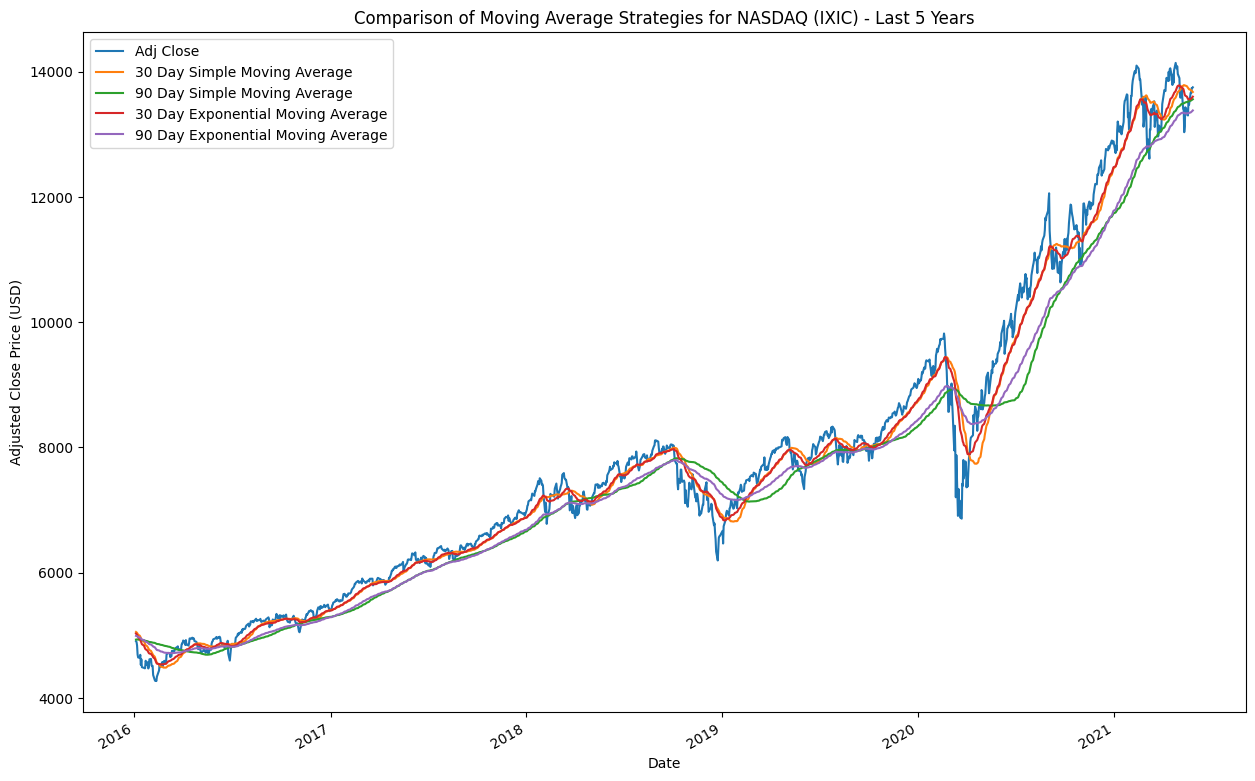

In [260]:
# Focus on the IXIC (NASDAQ) data to simplify our analysis.
ixic_data = data_frames_per_index["IXIC"]

# Plot the IXIC data to compare how the moving average strategies perform.
ixic_data.plot(
    x="Date",
    y=[
        "Adj Close",
        "30 Day Simple Moving Average",
        "90 Day Simple Moving Average",
        "30 Day Exponential Moving Average",
        "90 Day Exponential Moving Average",
    ],
    xlabel="Date",
    ylabel="Adjusted Close Price (USD)",
    title=f"Comparison of Moving Average Strategies for NASDAQ (IXIC)",
    figsize=(15, 10),
)

# Plot the IXIC data from the last five years to zoom into how the moving
# average strategies perform.
ixic_data_last_5y = ixic_data[(ixic_data["Date"] > "2016-01-01")]
ixic_data_last_5y.plot(
    x="Date",
    y=[
        "Adj Close",
        "30 Day Simple Moving Average",
        "90 Day Simple Moving Average",
        "30 Day Exponential Moving Average",
        "90 Day Exponential Moving Average",
    ],
    xlabel="Date",
    ylabel="Adjusted Close Price (USD)",
    title=f"Comparison of Moving Average Strategies for NASDAQ (IXIC) - Last 5 Years",
    figsize=(15, 10),
)


### Show Final Data After Preprocessing


<AxesSubplot: title={'center': 'Time Series Graph for NASDAQ (IXIC) - Last 5 Years'}, xlabel='Date', ylabel='Adjusted Close Price (USD)'>

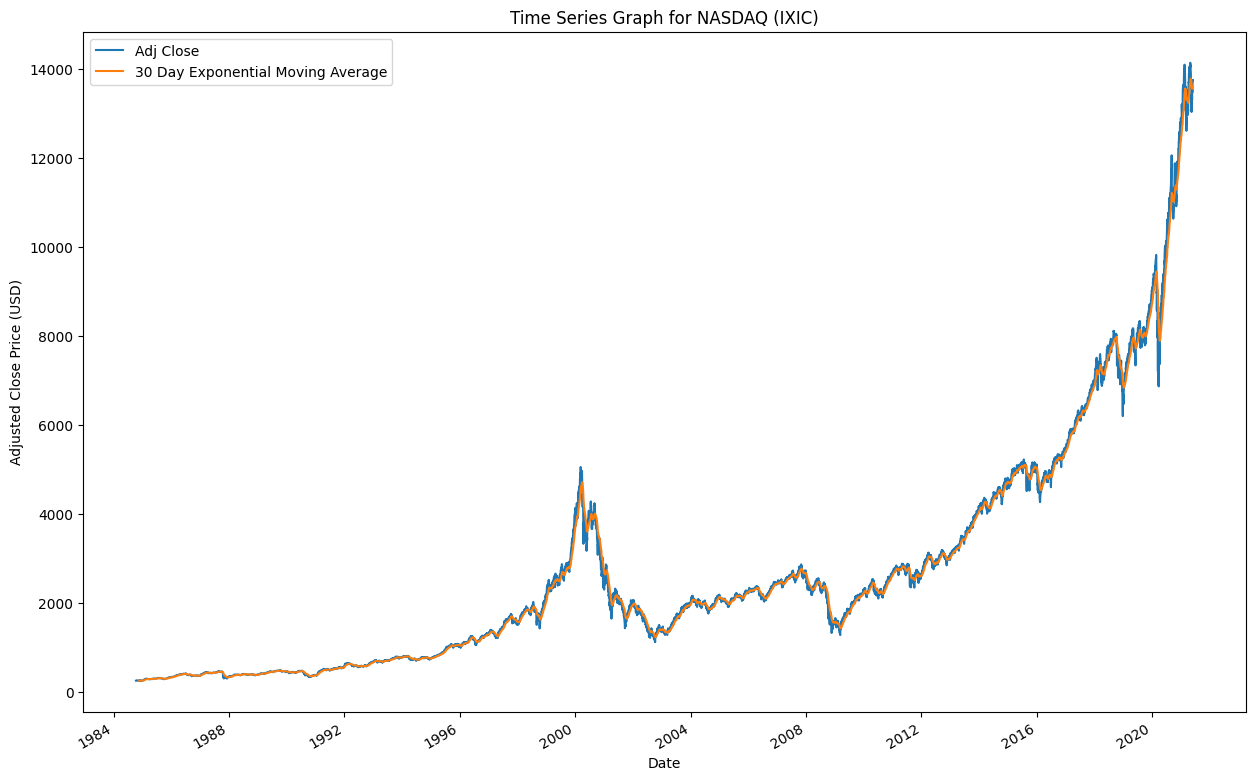

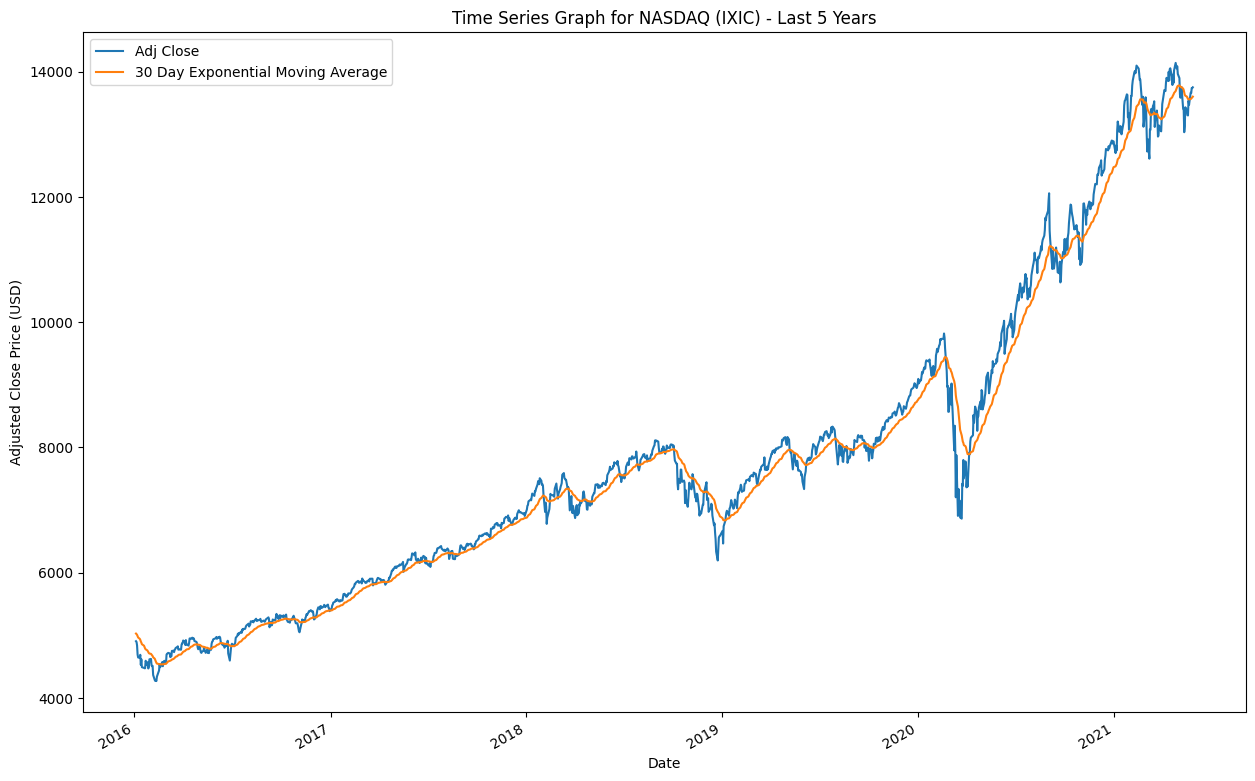

In [261]:
# Plot the IXIC data to show what we're working with.
ixic_data.plot(
    x="Date",
    y=[
        "Adj Close",
        "30 Day Exponential Moving Average",
    ],
    xlabel="Date",
    ylabel="Adjusted Close Price (USD)",
    title=f"Time Series Graph for NASDAQ (IXIC)",
    figsize=(15, 10),
)

# Show a zoomed in view using the last five years of data.
ixic_data_last_5y = ixic_data[ixic_data["Date"] > "2016-01-01"]
# Plot the IXIC data to show what we're working with.
ixic_data_last_5y.plot(
    x="Date",
    y=[
        "Adj Close",
        "30 Day Exponential Moving Average",
    ],
    xlabel="Date",
    ylabel="Adjusted Close Price (USD)",
    title=f"Time Series Graph for NASDAQ (IXIC) - Last 5 Years",
    figsize=(15, 10),
)

## Forecasting with Regression Models


### Generate Training and Test Data Sets for IXIC Index


In [262]:
# # Shift 30 day exponential average to the future by 1 day to exclude the current day's adj close.
# # TODO: Why do my regression models still give near identical results?
ixic_data["30 Day Exponential Moving Average"] = ixic_data[
    "30 Day Exponential Moving Average"
].shift(30)
display(ixic_data)
ixic_data.dropna(inplace=True)
ixic_data.reset_index(drop=True, inplace=True)
display(ixic_data)
# TODO: Recalculate moving average after removing all the invalid rows?

x = ixic_data[["30 Day Exponential Moving Average"]]
y = ixic_data[["Adj Close"]]
display(x)
display(y)

# Generate a training and test data set for the IXIC index.
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, shuffle=False)
# plt.scatter(x_test, y_test)
# x_train = x_train.reshape(-1, 1)
# y_train = y_train.reshape(-1, 1)
# x_test = x_test.reshape(-1, 1)
# y_test = y_test.reshape(-1, 1)
print("Training Data:")
display(x_train)
display(y_train)
print("Test Data:")
display(x_test)
display(y_test)

Index       Date          Open          High           Low  \
17405  IXIC 1984-10-11    244.199997    244.699997    244.199997   
17406  IXIC 1984-10-12    245.500000    246.199997    245.500000   
17407  IXIC 1984-10-15    246.800003    247.699997    246.800003   
17408  IXIC 1984-10-16    247.800003    247.899994    247.100006   
17409  IXIC 1984-10-17    247.100006    247.100006    246.800003   
...     ...        ...           ...           ...           ...   
26633  IXIC 2021-05-24  13557.209960  13708.849610  13551.009770   
26634  IXIC 2021-05-25  13721.540040  13751.139650  13631.799810   
26635  IXIC 2021-05-26  13693.940430  13750.160160  13679.589840   
26636  IXIC 2021-05-27  13742.589840  13776.519530  13701.629880   
26637  IXIC 2021-05-28  13792.049810  13820.870120  13747.610350   

              Close     Adj Close        Volume  30 Day Simple Moving Average  \
17405    244.699997    244.699997  6.286000e+07                           NaN   
17406    246.199997    246.199997  5.886000e+07                           NaN   
17407    247.699997    247.699997  6.182000e+07                           NaN   
17408    247.300003    247.300003  5.744000e+07                           NaN   
17409    247.100006    247.100006  6.467000e+07                           NaN   
...             ...           ...           ...                           ...   
26633  13661.169920  13661.169920  3.490650e+09                  13709.372265   
26634  13657.169920  13657.169920  4.084480e+09                  13698.074609   
26635  13738.000000  13738.000000  4.231140e+09                  13694.079948   
26636  13736.280270  13736.280270  5.057550e+09                  13683.997298   
26637  13748.740230  13748.740230  4.435220e+09                  13673.877311   

       90 Day Simple Moving Average  360 Day Simple Moving Average  \
17405                           NaN                            NaN   
17406                           NaN                            NaN   
17407                           NaN                            NaN   
17408                           NaN                            NaN   
17409                           NaN                            NaN   
...                             ...                            ...   
26633                  13534.521864                   11064.832267   
26634                  13540.572201                   11078.247350   
26635                  13548.788867                   11091.721739   
26636                  13554.778874                   11105.086518   
26637                  13558.017654                   11118.428434   

       30 Day Exponential Moving Average  90 Day Exponential Moving Average  
17405                                NaN                                NaN  
17406                                NaN                                NaN  
17407                                NaN                                NaN  
17408                                NaN                                NaN  
17409                                NaN                                NaN  
...                                  ...                                ...  
26633                       13430.406332                       13347.210109  
26634                       13466.902673                       13354.022413  
26635                       13492.124426                       13362.461481  
26636                       13527.391222                       13370.677278  
26637                       13561.258875                       13378.986354  

[9233 rows x 13 columns]

Index       Date          Open          High           Low         Close  \
0     IXIC 1986-03-17    370.200012    371.899994    369.200012    370.000000   
1     IXIC 1986-03-18    371.000000    371.500000    370.000000    371.500000   
2     IXIC 1986-03-19    372.399994    372.700012    371.500000    371.700012   
3     IXIC 1986-03-20    372.700012    372.799988    371.700012    372.700012   
4     IXIC 1986-03-21    373.100006    373.600006    372.200012    372.600006   
...    ...        ...           ...           ...           ...           ...   
8869  IXIC 2021-05-24  13557.209960  13708.849610  13551.009770  13661.169920   
8870  IXIC 2021-05-25  13721.540040  13751.139650  13631.799810  13657.169920   
8871  IXIC 2021-05-26  13693.940430  13750.160160  13679.589840  13738.000000   
8872  IXIC 2021-05-27  13742.589840  13776.519530  13701.629880  13736.280270   
8873  IXIC 2021-05-28  13792.049810  13820.870120  13747.610350  13748.740230   

         Adj Close        Volume  30 Day Simple Moving Average  \
0       370.000000  1.295000e+08                    354.848331   
1       371.500000  1.395000e+08                    355.981664   
2       371.700012  1.369000e+08                    357.108331   
3       372.700012  1.514000e+08                    358.234999   
4       372.600006  1.329000e+08                    359.294999   
...            ...           ...                           ...   
8869  13661.169920  3.490650e+09                  13709.372265   
8870  13657.169920  4.084480e+09                  13698.074609   
8871  13738.000000  4.231140e+09                  13694.079948   
8872  13736.280270  5.057550e+09                  13683.997298   
8873  13748.740230  4.435220e+09                  13673.877311   

      90 Day Simple Moving Average  360 Day Simple Moving Average  \
0                       331.131666                     291.035139   
1                       331.962777                     291.387361   
2                       332.787222                     291.735972   
3                       333.595000                     292.083195   
4                       334.376111                     292.431250   
...                            ...                            ...   
8869                  13534.521864                   11064.832267   
8870                  13540.572201                   11078.247350   
8871                  13548.788867                   11091.721739   
8872                  13554.778874                   11105.086518   
8873                  13558.017654                   11118.428434   

      30 Day Exponential Moving Average  90 Day Exponential Moving Average  
0                            326.637225                         334.800629  
1                            327.338049                         335.607473  
2                            328.019465                         336.400970  
3                            328.721435                         337.199002  
4                            329.500696                         337.977284  
...                                 ...                                ...  
8869                       13430.406332                       13347.210109  
8870                       13466.902673                       13354.022413  
8871                       13492.124426                       13362.461481  
8872                       13527.391222                       13370.677278  
8873                       13561.258875                       13378.986354  

[8874 rows x 13 columns]

30 Day Exponential Moving Average
0                            326.637225
1                            327.338049
2                            328.019465
3                            328.721435
4                            329.500696
...                                 ...
8869                       13430.406332
8870                       13466.902673
8871                       13492.124426
8872                       13527.391222
8873                       13561.258875

[8874 rows x 1 columns]

Adj Close
0       370.000000
1       371.500000
2       371.700012
3       372.700012
4       372.600006
...            ...
8869  13661.169920
8870  13657.169920
8871  13738.000000
8872  13736.280270
8873  13748.740230

[8874 rows x 1 columns]

Training Data:


30 Day Exponential Moving Average
0                            326.637225
1                            327.338049
2                            328.019465
3                            328.721435
4                            329.500696
...                                 ...
7094                        4265.667381
7095                        4263.641745
7096                        4257.831315
7097                        4250.953810
7098                        4244.812258

[7099 rows x 1 columns]

Adj Close
0      370.000000
1      371.500000
2      371.700012
3      372.700012
4      372.600006
...           ...
7094  4080.760010
7095  4067.669922
7096  4051.500000
7097  4071.870117
7098  4143.859863

[7099 rows x 1 columns]

Test Data:


30 Day Exponential Moving Average
7099                        4241.855999
7100                        4243.545292
7101                        4245.668819
7102                        4245.157297
7103                        4237.581341
...                                 ...
8869                       13430.406332
8870                       13466.902673
8871                       13492.124426
8872                       13527.391222
8873                       13561.258875

[1775 rows x 1 columns]

Adj Close
7099   4130.169922
7100   4100.629883
7101   4069.290039
7102   4090.590088
7103   4125.810059
...            ...
8869  13661.169920
8870  13657.169920
8871  13738.000000
8872  13736.280270
8873  13748.740230

[1775 rows x 1 columns]

### Ridge Regression


#### Tune Alpha Hyperparameter for Ridge


In [263]:
# Use grid search to perform hyperparameter tuning on the ridge regression
# model.
parameters = [{"alpha": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}]
model = Ridge()
grid_search = GridSearchCV(
    cv=5,
    estimator=model,
    param_grid=parameters,
    return_train_score=True,
    scoring="r2",
)
grid_search.fit(x_train, y_train)
best_ridge_alpha = grid_search.best_params_["alpha"]
print(f"Best Ridge Alpha: {best_ridge_alpha}")
print(f"Best Score: {grid_search.score(x_test, y_test)}")


Best Ridge Alpha: 0.1
Best Score: 0.9499724363550578


#### Predict using Ridge with Best Alpha Parameter


array([[ 4259.46709199],
       [ 4261.15226185],
       [ 4263.27060601],
       ...,
       [13487.1583602 ],
       [13522.33908084],
       [13556.12407273]])

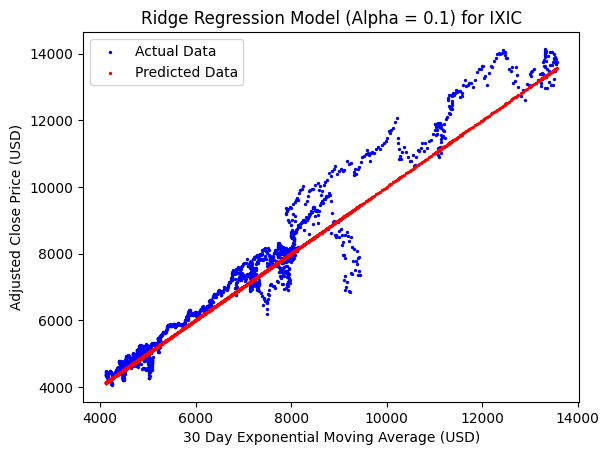

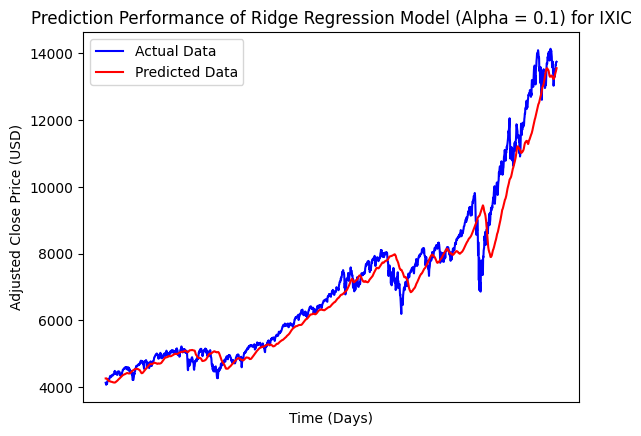

Model Score: 0.9499724363550578
Mean Absolute Error (MAE): 392.50735268102807
Root Mean Squared Error (RMSE): 559.9741592052716


In [264]:
# Define the ridge regression model.
ridge_model = Ridge(alpha=best_ridge_alpha)
ridge_model.fit(x_train, y_train)
y_pred = ridge_model.predict(x_test)
display(y_pred)

# Plot how well the ridge regression model fits the relationship between
# exponential moving average and adjusted close price.
plt.scatter(x_test, y_test, s=2, color="blue", label="Actual Data")
plt.scatter(x_test, y_pred, s=2, color="red", label="Predicted Data")
plt.xlabel("30 Day Exponential Moving Average (USD)")
plt.ylabel("Adjusted Close Price (USD)")
plt.title(f"Ridge Regression Model (Alpha = {best_ridge_alpha}) for IXIC")
plt.legend()
plt.show()

# Compare the actual and predicted values.
y_test_vals = np.array(y_test["Adj Close"]).reshape(-1, 1)
# display(y_test_vals)
# display(y_pred)
plt.plot(y_test_vals, color="blue", label="Actual Data")
plt.plot(y_pred, color="red", label="Predicted Data")
plt.xlabel("Time (Days)")
plt.ylabel("Adjusted Close Price (USD)")
# TODO: Add test dates (last 20% of data) to x-ticks.
# test_dates = ixic_data["Date"].tail(len(y_test_vals)).values
# plt.xticks([np.datetime64(val).astype(datetime) for val in test_dates])
# plt.xticks([val for val in ixic_data["Date"].tail(len(y_test_vals))])
plt.xticks([])
plt.title(
    f"Prediction Performance of Ridge Regression Model (Alpha = {best_ridge_alpha}) "
    "for IXIC"
)
plt.legend()
plt.show()

print(f"Model Score: {ridge_model.score(x_test, y_test)}")
print(f"Mean Absolute Error (MAE): {metrics.mean_absolute_error(y_test, y_pred)}")
print(
    f"Root Mean Squared Error (RMSE): {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}"
)


### LASSO Regression

#### Tune Alpha Hyperparameter for LASSO


In [265]:
# Use grid search to perform hyperparameter tuning on the LASSO regression
# model.
parameters = [{"alpha": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}]
model = Lasso()
grid_search = GridSearchCV(
    cv=5,
    estimator=model,
    param_grid=parameters,
    return_train_score=True,
    scoring="r2",
)
grid_search.fit(x_train, y_train)
best_lasso_alpha = grid_search.best_params_["alpha"]
print(f"Best LASSO Alpha: {best_lasso_alpha}")
print(f"Best Score: {grid_search.score(x_test, y_test)}")


Best LASSO Alpha: 0.1
Best Score: 0.949972389107981


#### Predict Using LASSO with Optimal Alpha Parameter


array([ 4259.46684527,  4261.15201497,  4263.27035892, ...,
       13487.15722883, 13522.3379461 , 13556.12293475])

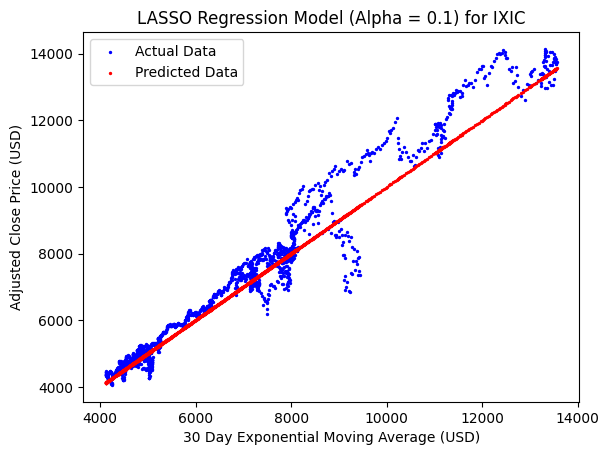

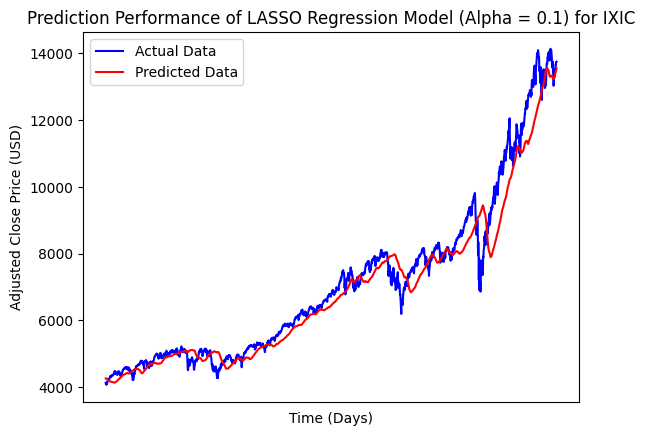

Model Score: 0.949972389107981
Mean Absolute Error (MAE): 392.50763009979676
Root Mean Squared Error (RMSE): 559.9744236308596


In [266]:
# Define the LASSO regression model.
lasso_model = Lasso(alpha=best_lasso_alpha)
lasso_model.fit(x_train, y_train)
y_pred = lasso_model.predict(x_test)
display(y_pred)

# Plot how well the LASSO regression model fits the relationship between
# exponential moving average and adjusted close price.
plt.scatter(x_test, y_test, s=2, color="blue", label="Actual Data")
plt.scatter(x_test, y_pred, s=2, color="red", label="Predicted Data")
plt.xlabel("30 Day Exponential Moving Average (USD)")
plt.ylabel("Adjusted Close Price (USD)")
plt.title(f"LASSO Regression Model (Alpha = {best_lasso_alpha}) for IXIC")
plt.legend()
plt.show()

# Compare the actual and predicted values.
y_test_vals = np.array(y_test["Adj Close"]).reshape(-1, 1)
# display(y_test_vals)
# display(y_pred)
plt.plot(y_test_vals, color="blue", label="Actual Data")
plt.plot(y_pred, color="red", label="Predicted Data")
plt.xlabel("Time (Days)")
plt.ylabel("Adjusted Close Price (USD)")
# TODO: Add test dates (last 20% of data) to x-ticks.
# test_dates = ixic_data["Date"].tail(len(y_test_vals)).values
# plt.xticks([np.datetime64(val).astype(datetime) for val in test_dates])
# plt.xticks([val for val in ixic_data["Date"].tail(len(y_test_vals))])
plt.xticks([])
plt.title(
    f"Prediction Performance of LASSO Regression Model (Alpha = {best_lasso_alpha}) "
    "for IXIC"
)
plt.legend()
plt.show()

print(f"Model Score: {lasso_model.score(x_test, y_test)}")
print(f"Mean Absolute Error (MAE): {metrics.mean_absolute_error(y_test, y_pred)}")
print(
    f"Root Mean Squared Error (RMSE): {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}"
)


### Polynomial Regression

#### Tune Poly Degree Hyperparameter for Polynomial

In [267]:
# Use grid search to perform hyperparameter tuning on the polynomial regression
# model.
parameters = [{"poly__degree": [2, 3, 4, 5, 6, 7, 8, 9, 10]}]
pipeline = Pipeline(
    steps=[
        ("poly", PolynomialFeatures()),
        ("linear", LinearRegression()),
    ]
)
grid_search = GridSearchCV(
    cv=5,
    estimator=pipeline,
    param_grid=parameters,
    return_train_score=True,
    scoring="r2",
)
grid_search.fit(x_train, y_train)
best_poly_degree = grid_search.best_params_["poly__degree"]
print(f"Best Polynomial Degree: {best_poly_degree}")
print(f"Best Score: {grid_search.score(x_test, y_test)}")


Best Polynomial Degree: 2
Best Score: 0.7527729325848969


#### Predict Using Polynomial with Optimal Degree


array([[ 4165.16791584],
       [ 4166.68486833],
       [ 4168.59158385],
       ...,
       [10666.44339646],
       [10684.31942422],
       [10701.43684636]])

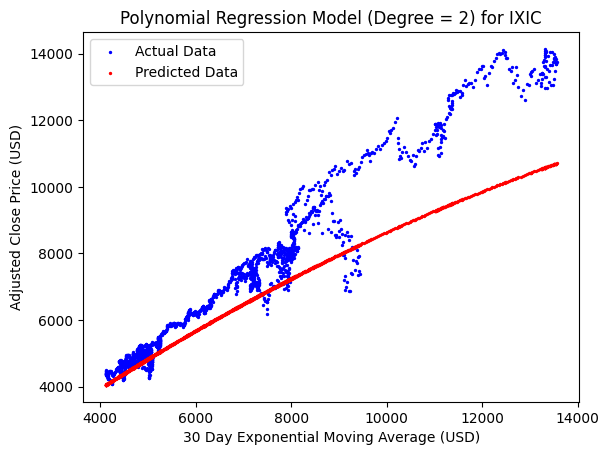

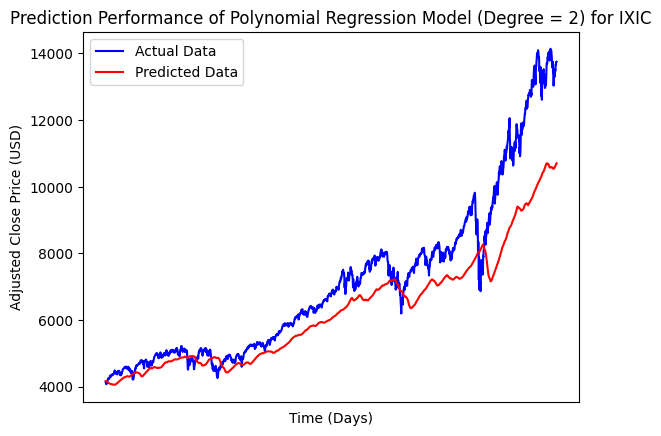

Model Score: 0.7527729325848969
Mean Absolute Error (MAE): 883.191319745268
Root Mean Squared Error (RMSE): 1244.8336468394023


In [268]:
# Fit polynomial regression with degree 2 to the dataset.
poly_reg_deg_2 = PolynomialFeatures(degree=best_poly_degree)
x_train_poly = poly_reg_deg_2.fit_transform(x_train)

# Define the polynomial regression model.
poly_model = LinearRegression()
poly_model.fit(x_train_poly, y_train)
x_test_poly = poly_reg_deg_2.fit_transform(x_test)
y_pred = poly_model.predict(x_test_poly)
display(y_pred)

# Plot how well the polynomial regression model fits the relationship between
# exponential moving average and adjusted close price.
plt.scatter(x_test, y_test, s=2, color="blue", label="Actual Data")
plt.scatter(x_test, y_pred, s=2, color="red", label="Predicted Data")
plt.xlabel("30 Day Exponential Moving Average (USD)")
plt.ylabel("Adjusted Close Price (USD)")
plt.title(f"Polynomial Regression Model (Degree = {best_poly_degree}) for IXIC")
plt.legend()
plt.show()

# Compare the actual and predicted values.
y_test_vals = np.array(y_test["Adj Close"]).reshape(-1, 1)
# display(y_test_vals)
# display(y_pred)
plt.plot(y_test_vals, color="blue", label="Actual Data")
plt.plot(y_pred, color="red", label="Predicted Data")
plt.xlabel("Time (Days)")
plt.ylabel("Adjusted Close Price (USD)")
# TODO: Add test dates (last 20% of data) to x-ticks.
# test_dates = ixic_data["Date"].tail(len(y_test_vals)).values
# plt.xticks([np.datetime64(val).astype(datetime) for val in test_dates])
# plt.xticks([val for val in ixic_data["Date"].tail(len(y_test_vals))])
plt.xticks([])
plt.title(
    "Prediction Performance of Polynomial Regression Model "
    f"(Degree = {best_poly_degree}) for IXIC"
)
plt.legend()
plt.show()

print(f"Model Score: {poly_model.score(x_test_poly, y_test)}")
print(f"Mean Absolute Error (MAE): {metrics.mean_absolute_error(y_test, y_pred)}")
print(
    f"Root Mean Squared Error (RMSE): {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}"
)


## Discussion of Results


### Comparison to Naive Benchmark

Naive Benchmark R^2 Score: 0.9887038438093156
Naive Benchmark MAE: 155.81090510425145
Naive Benchmark RMSE: 277.7004089121447


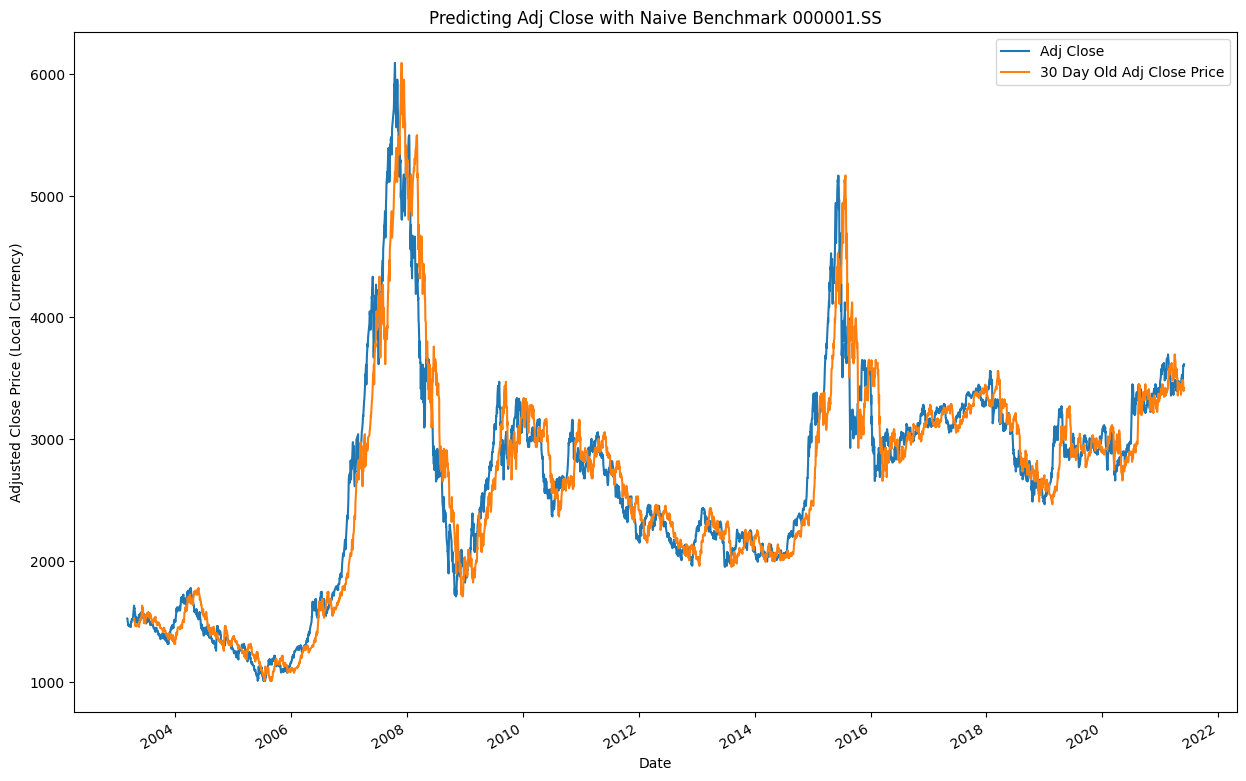

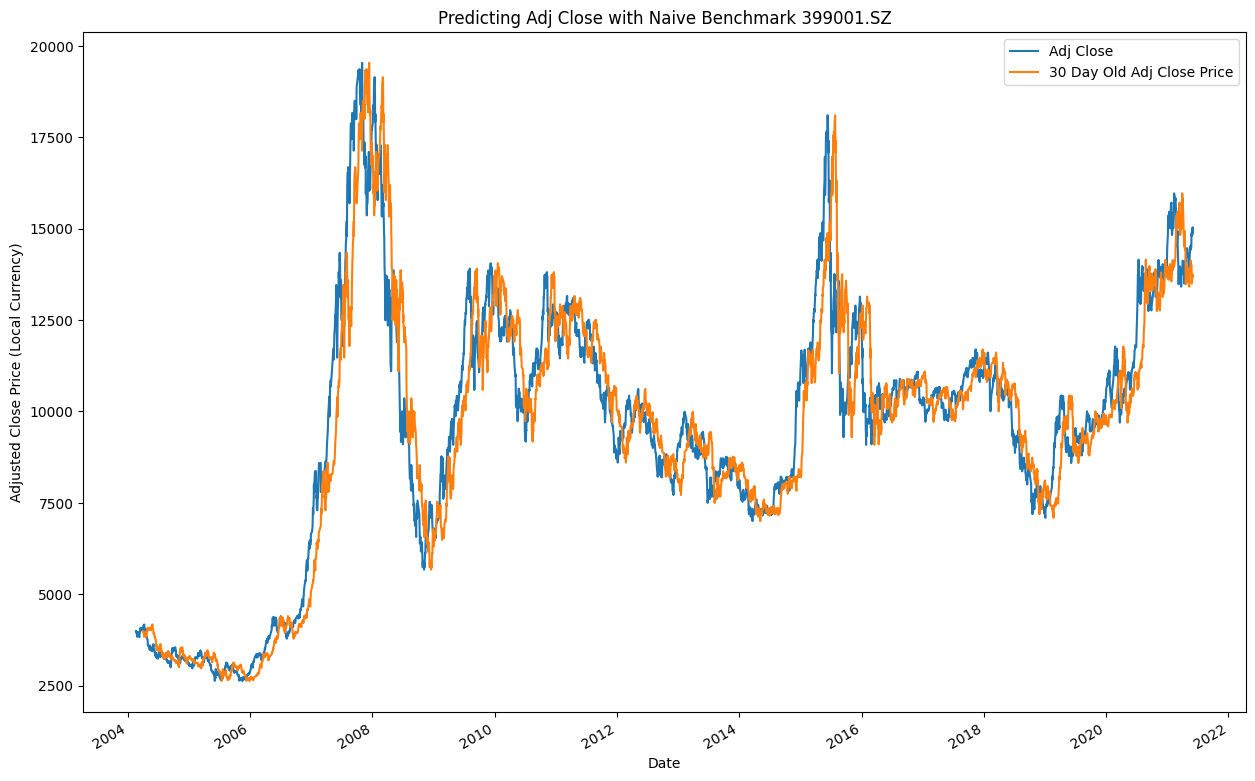

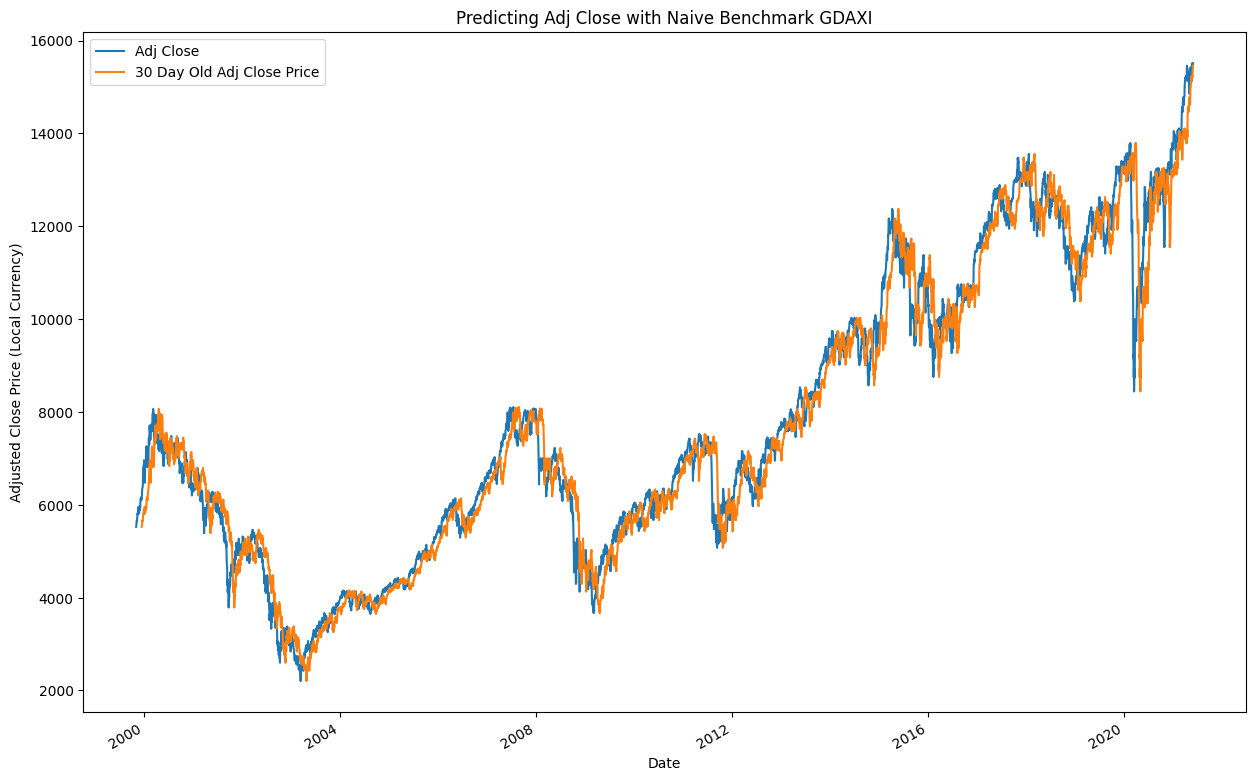

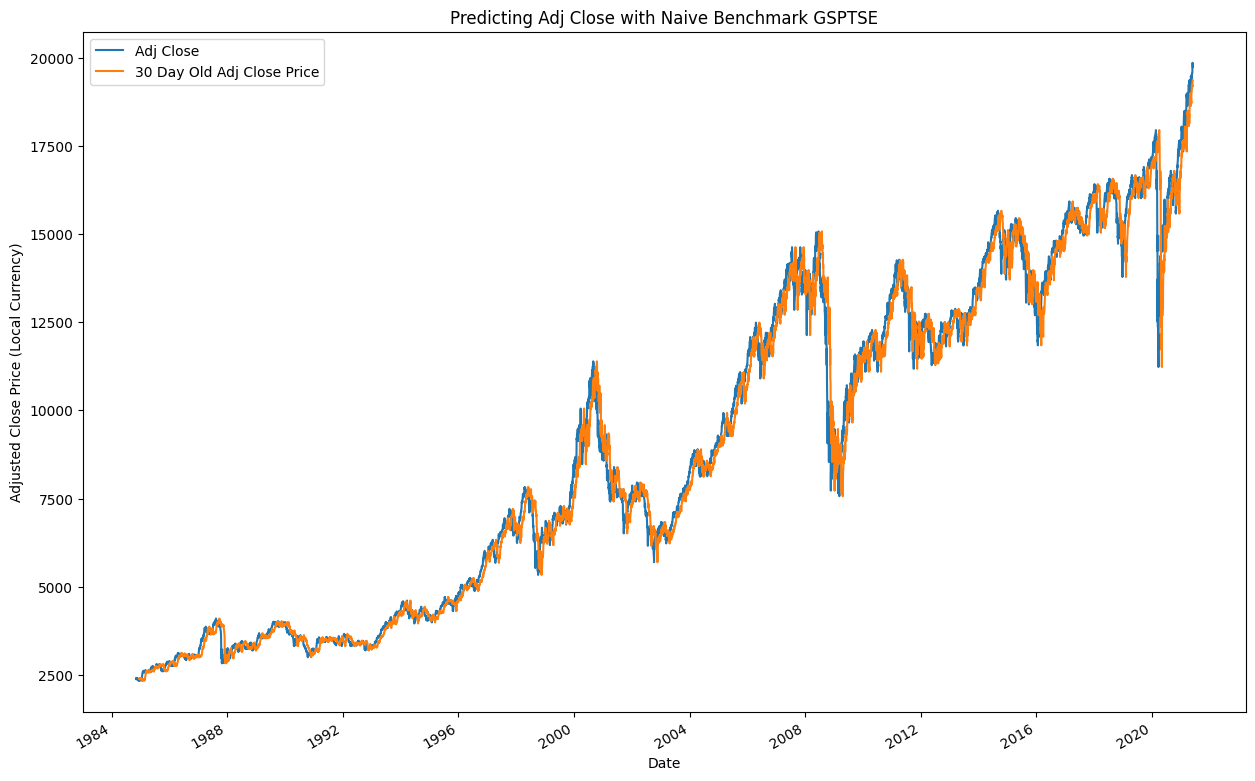

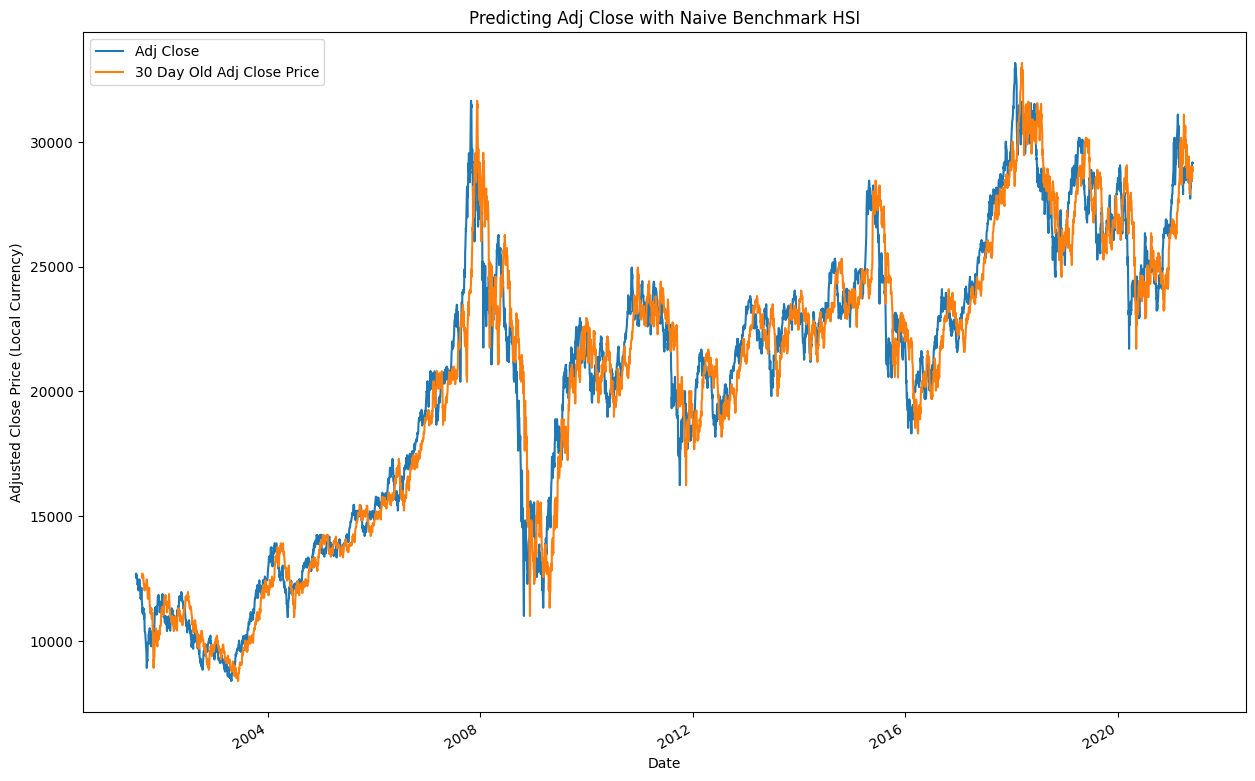

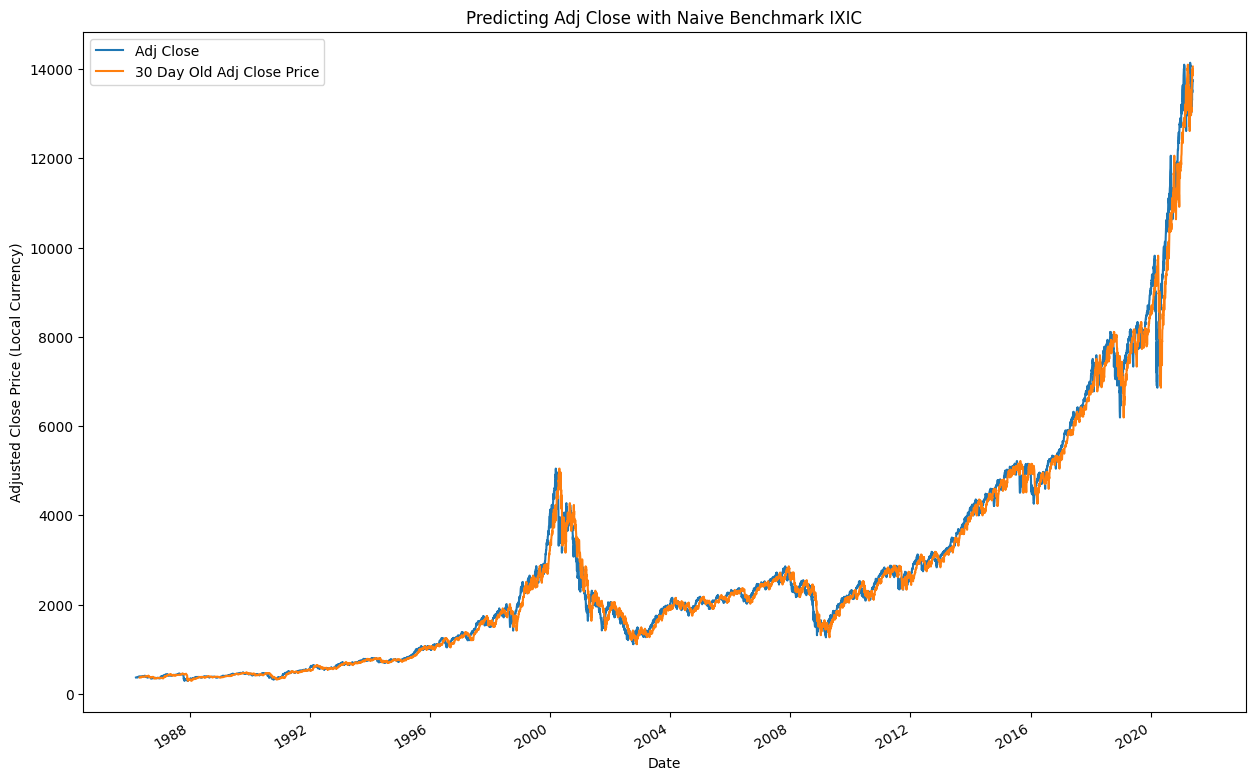

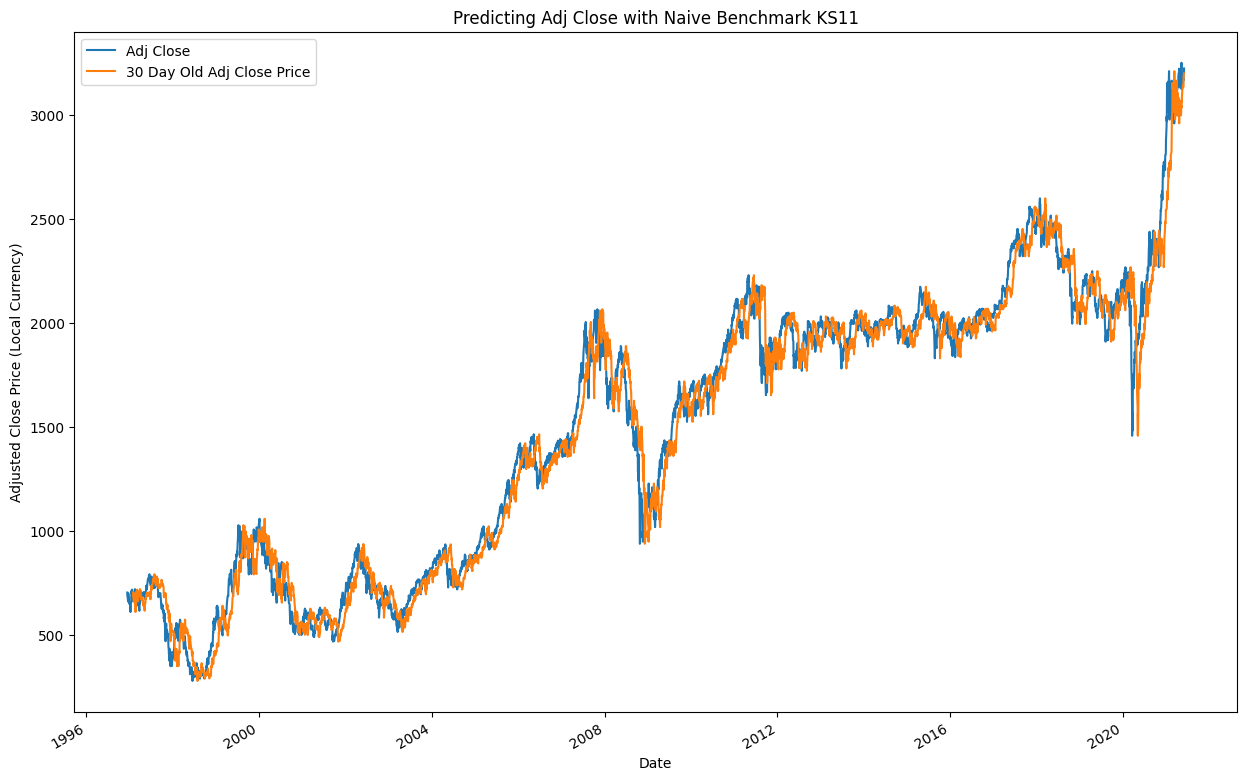

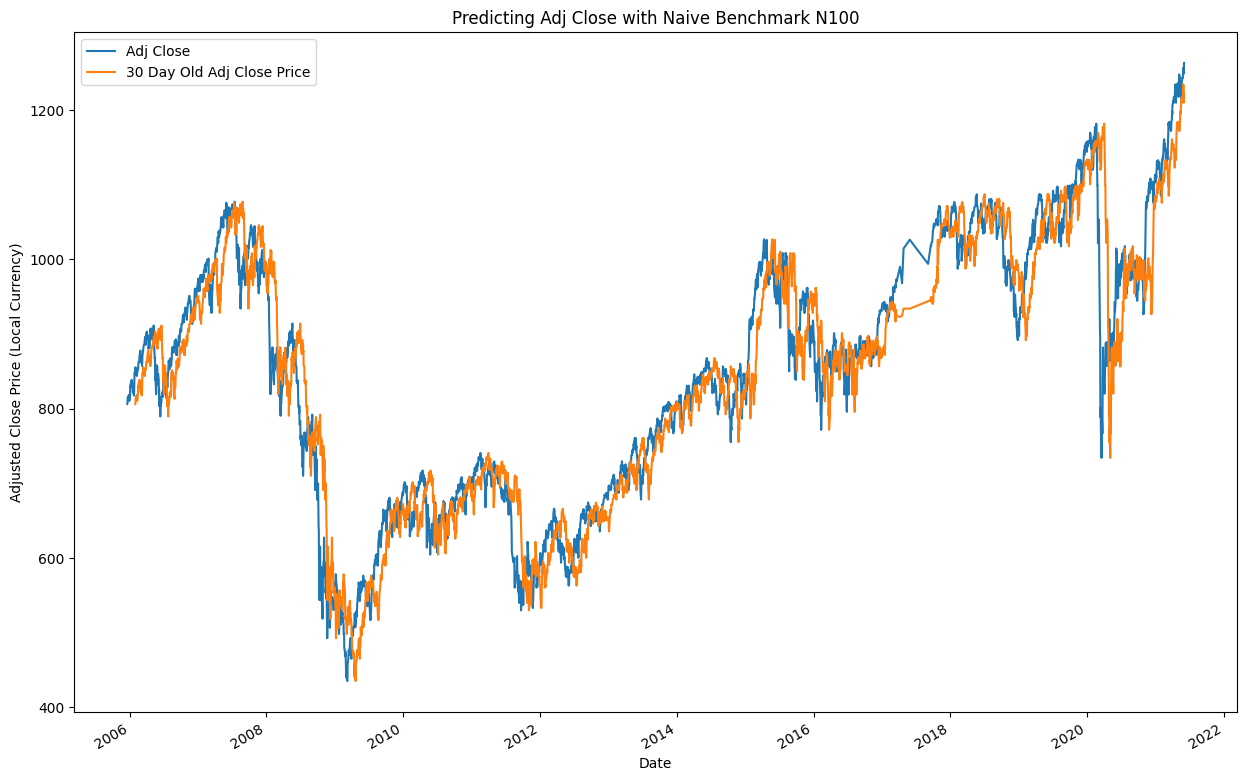

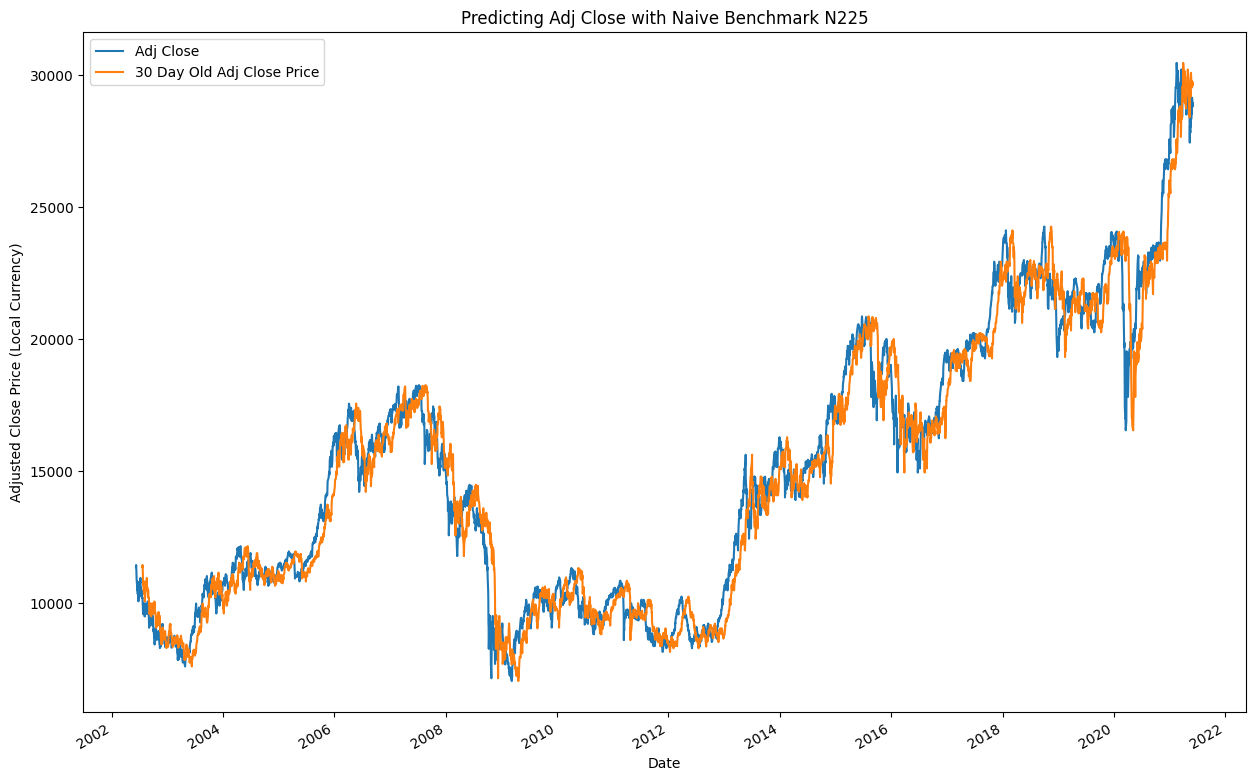

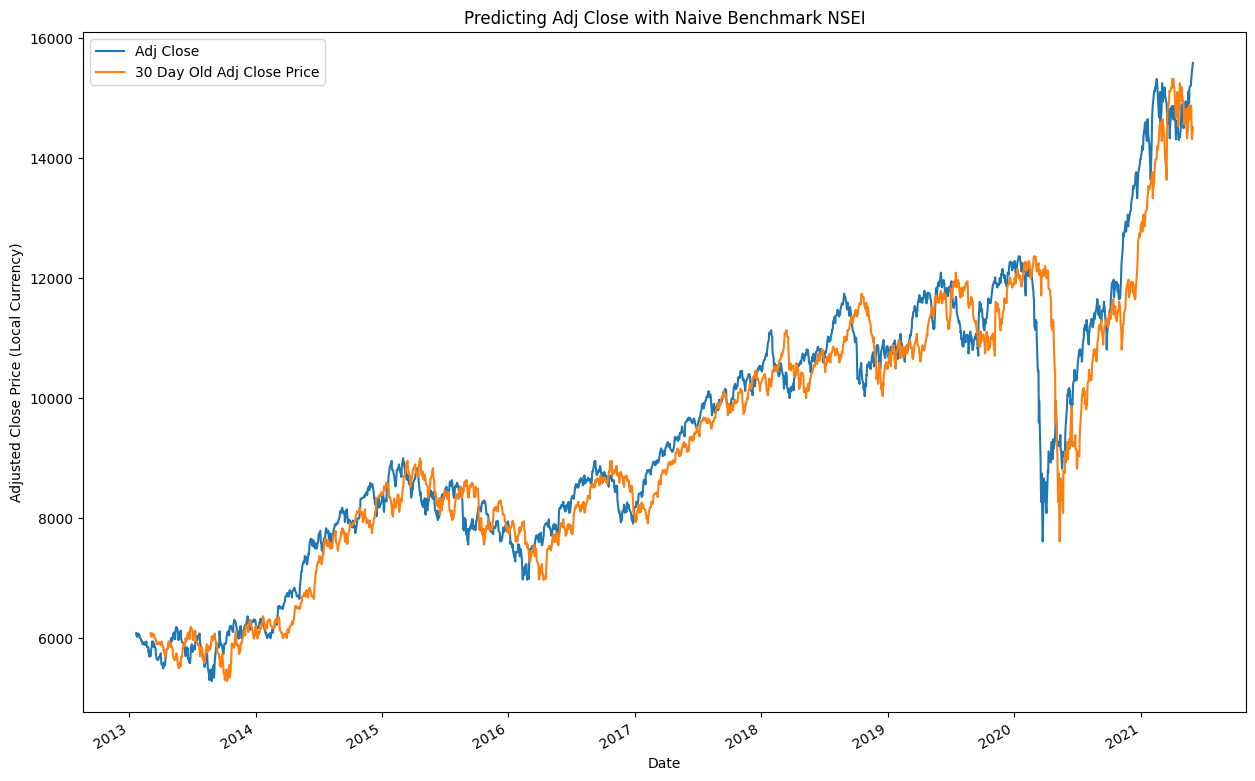

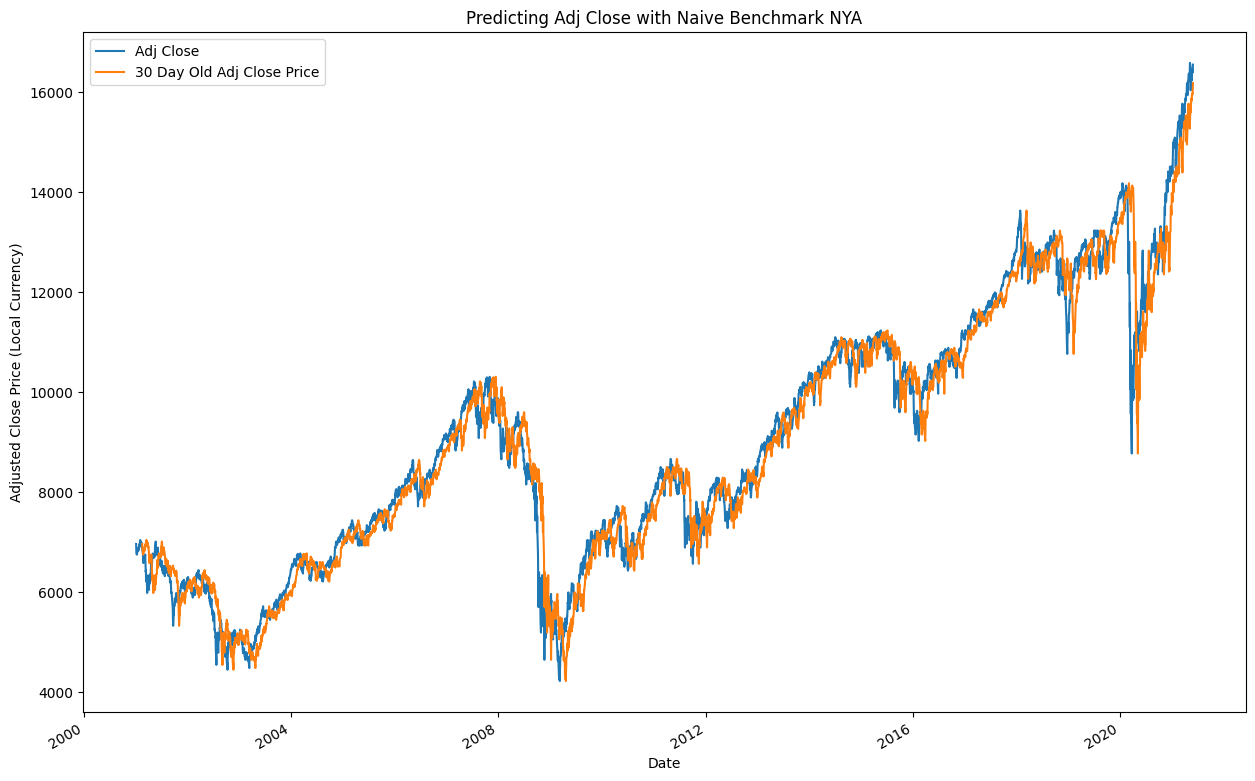

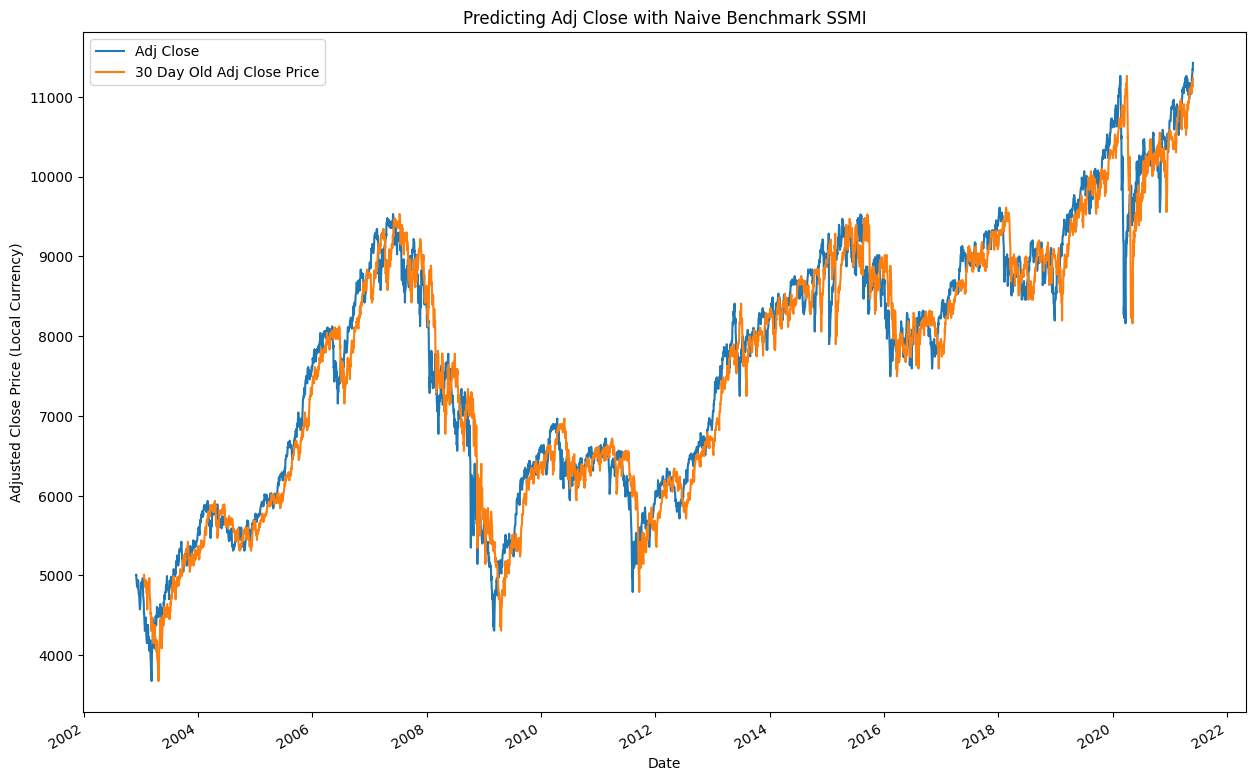

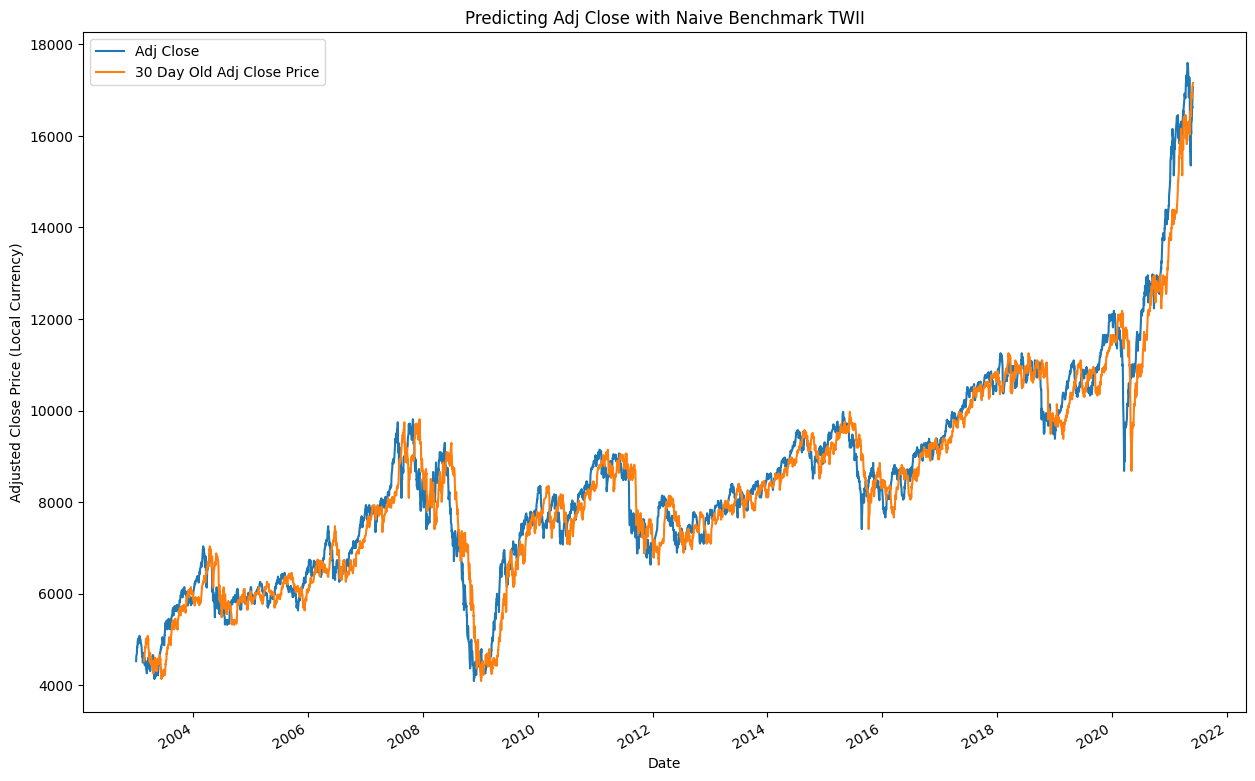

In [269]:
# Use 30 day old price as the prediction for that day.
for index in data_frames_per_index.keys():
    data_frames_per_index[index]["30 Day Old Adj Close Price"] = data_frames_per_index[
        index
    ]["Adj Close"].shift(30)

# Visualise how well the naive benchmark predicts prices 30 days in advance.
for index in data_frames_per_index.keys():
    data_frames_per_index[index].plot(
        x="Date",
        y=[
            "Adj Close",
            "30 Day Old Adj Close Price",
        ],
        xlabel="Date",
        ylabel="Adjusted Close Price (Local Currency)",
        title=f"Predicting Adj Close with Naive Benchmark {index}",
        figsize=(15, 10),
    )

# Remove values that are NaN.
for index in data_frames_per_index.keys():
    data_frames_per_index[index] = data_frames_per_index[index].dropna()

# Calculate R^2 score for the naive benchmark.
naive_r2_score = metrics.r2_score(
    data_frames_per_index["IXIC"]["Adj Close"],
    data_frames_per_index["IXIC"]["30 Day Old Adj Close Price"],
)
# Calculate MAE for the naive benchmark.
naive_mae = metrics.mean_absolute_error(
    data_frames_per_index["IXIC"]["Adj Close"],
    data_frames_per_index["IXIC"]["30 Day Old Adj Close Price"],
)
# Calculate RMSE for the naive benchmark.
naive_rmse = np.sqrt(
    metrics.mean_squared_error(
        data_frames_per_index["IXIC"]["Adj Close"],
        data_frames_per_index["IXIC"]["30 Day Old Adj Close Price"],
    )
)
print(f"Naive Benchmark R^2 Score: {naive_r2_score}")
print(f"Naive Benchmark MAE: {naive_mae}")
print(f"Naive Benchmark RMSE: {naive_rmse}")


### Using Log Returns as Target Variable


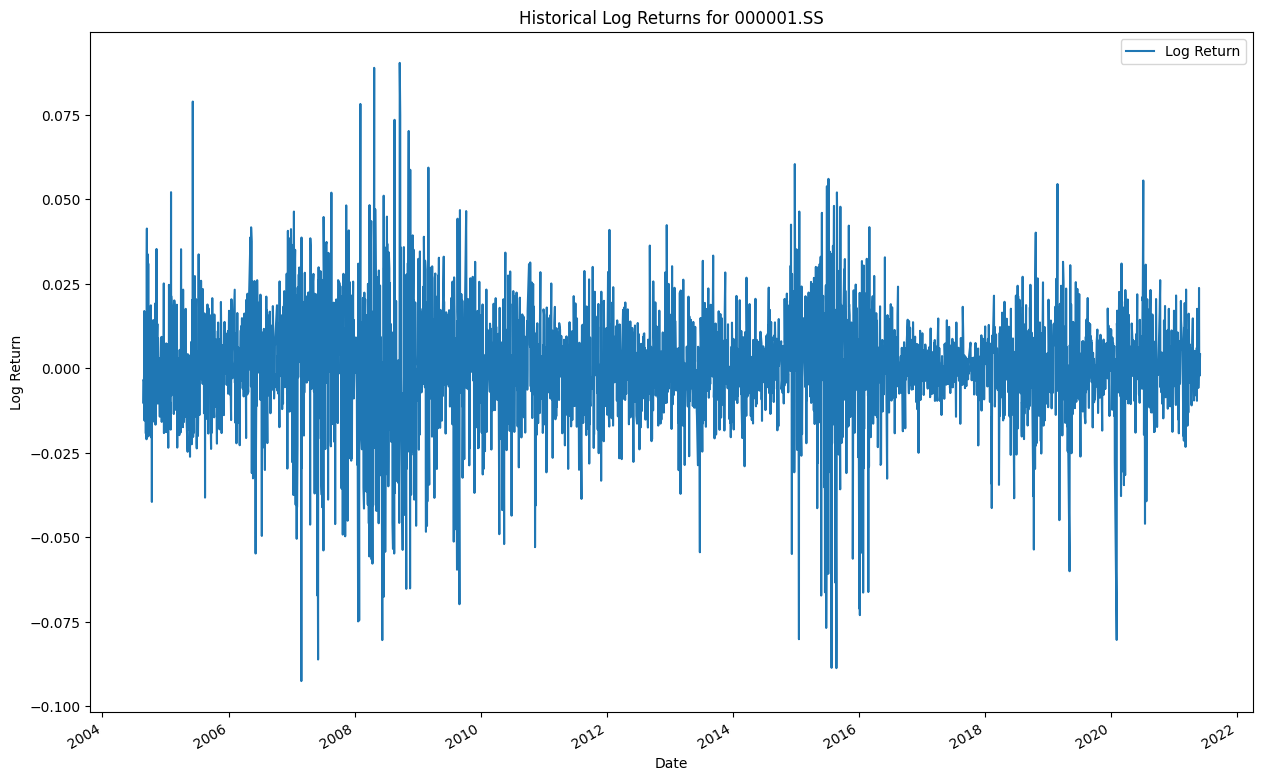

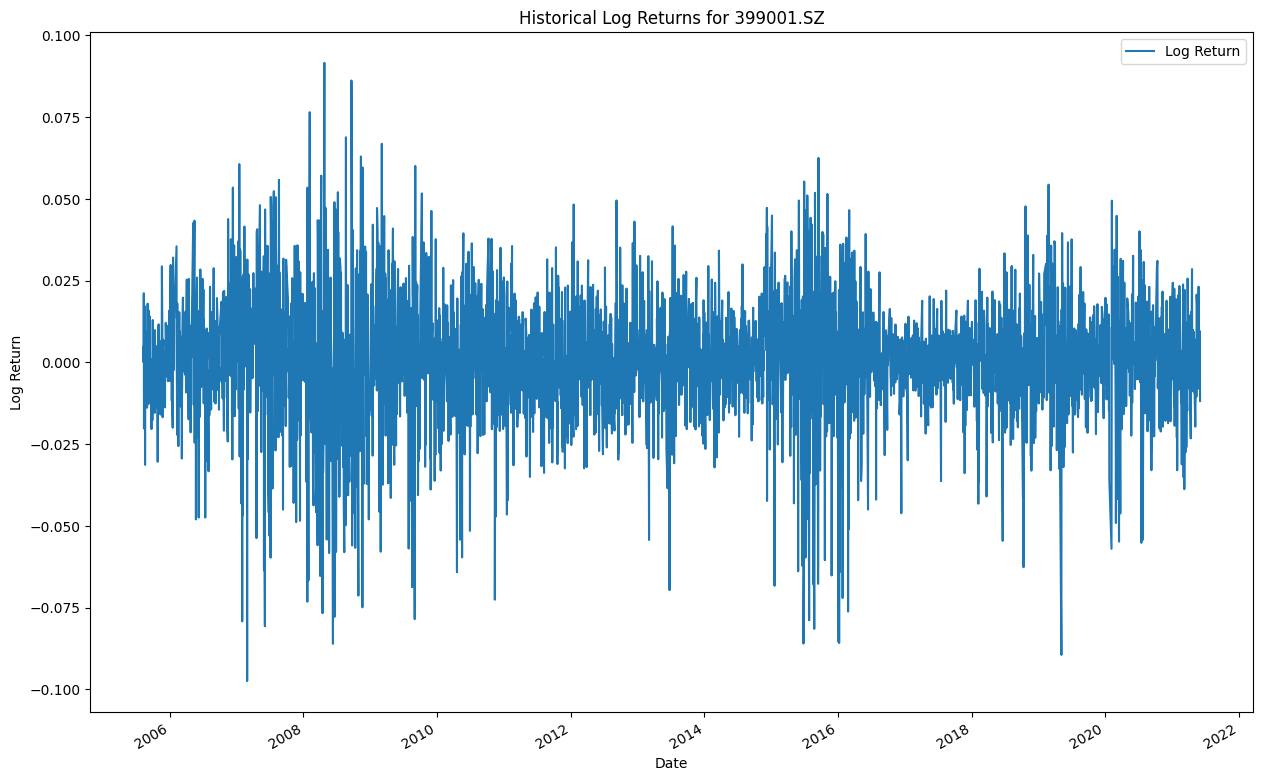

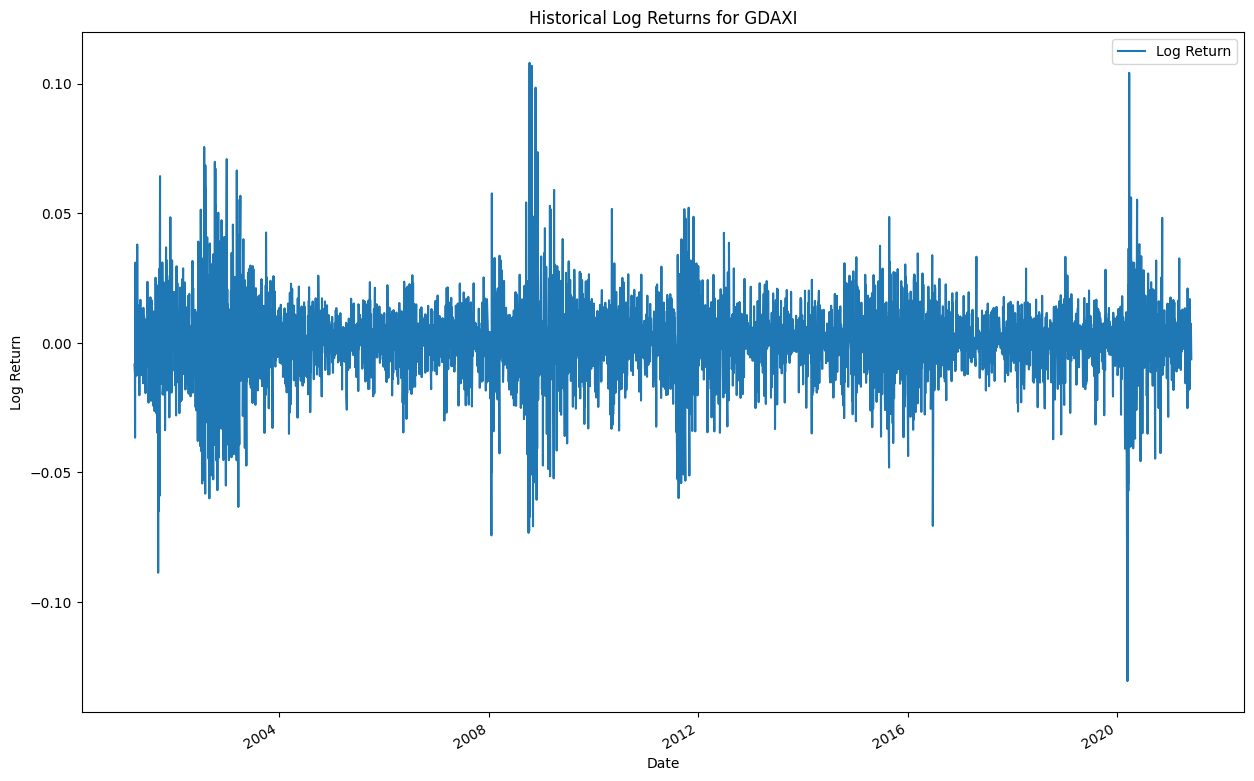

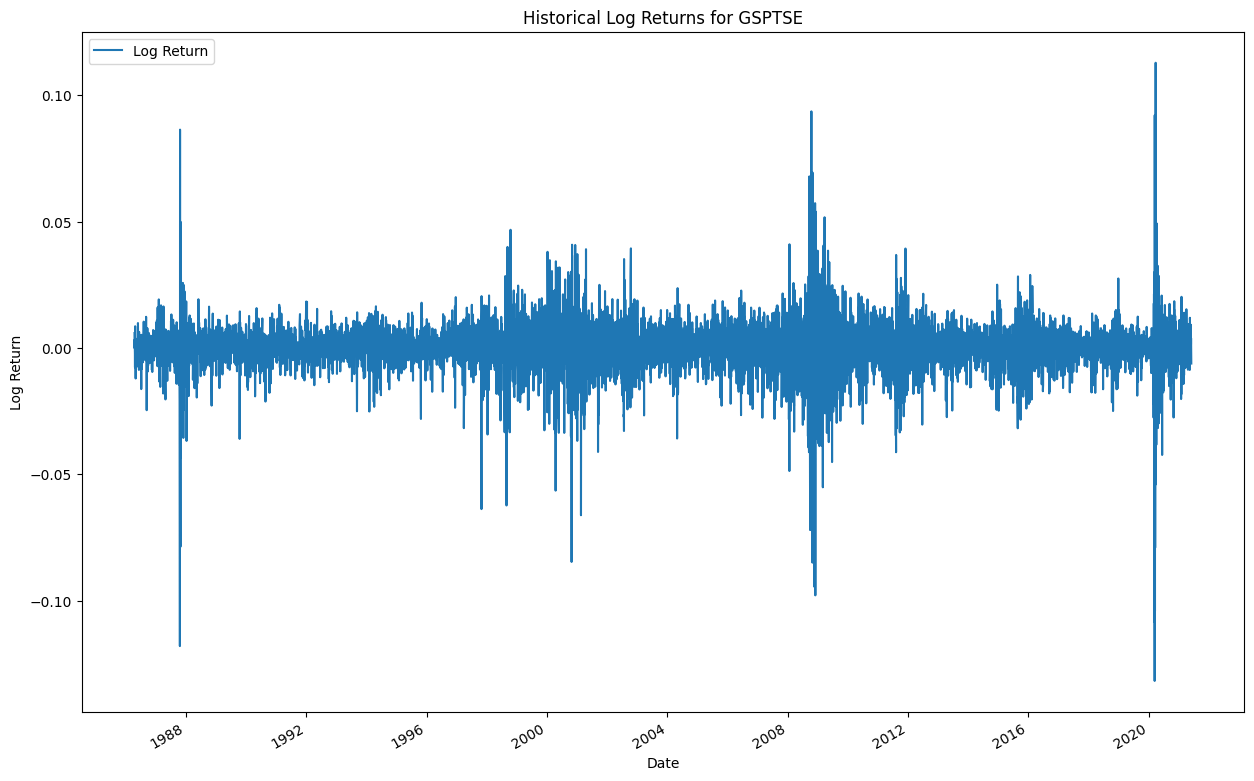

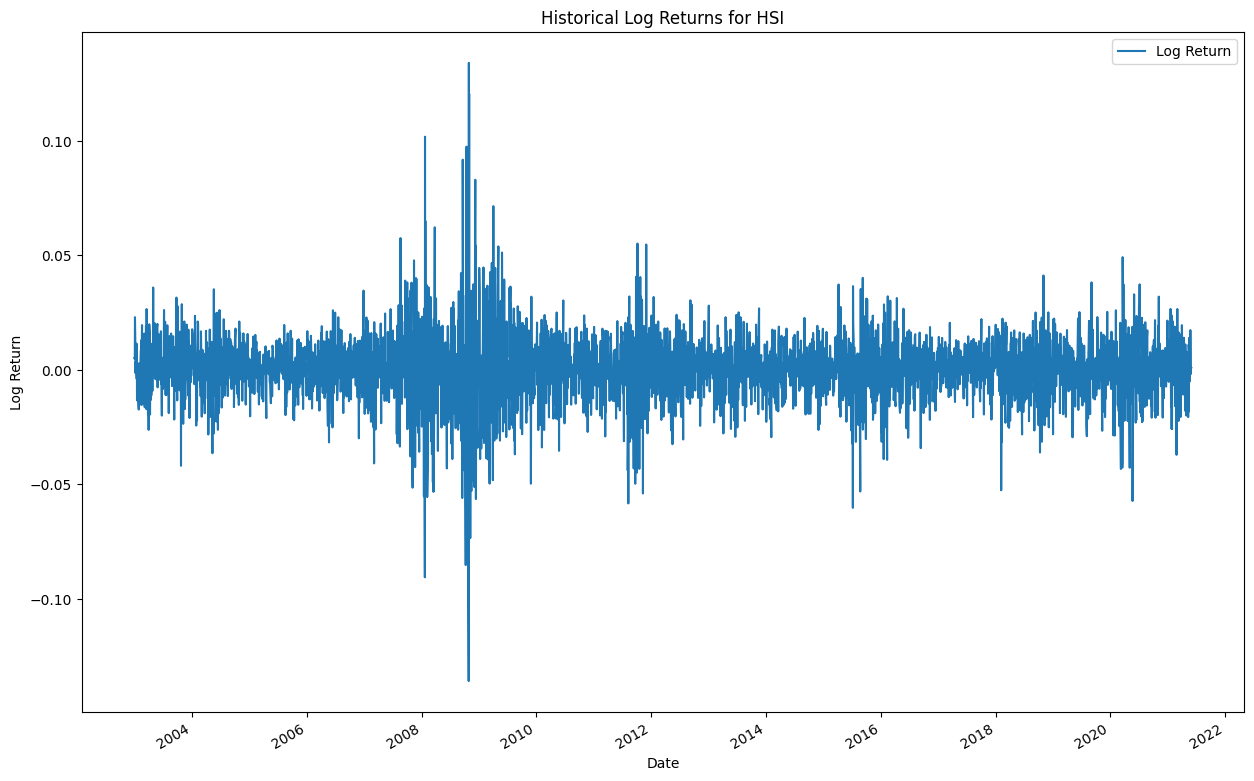

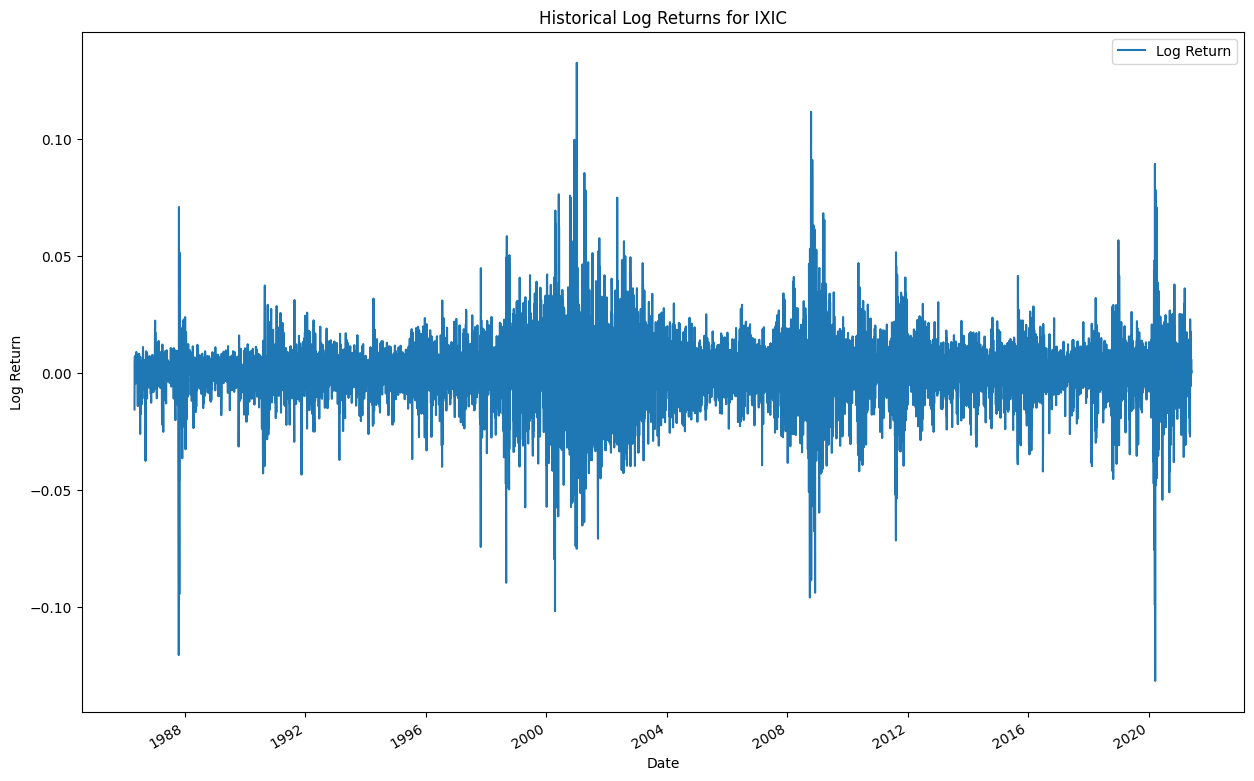

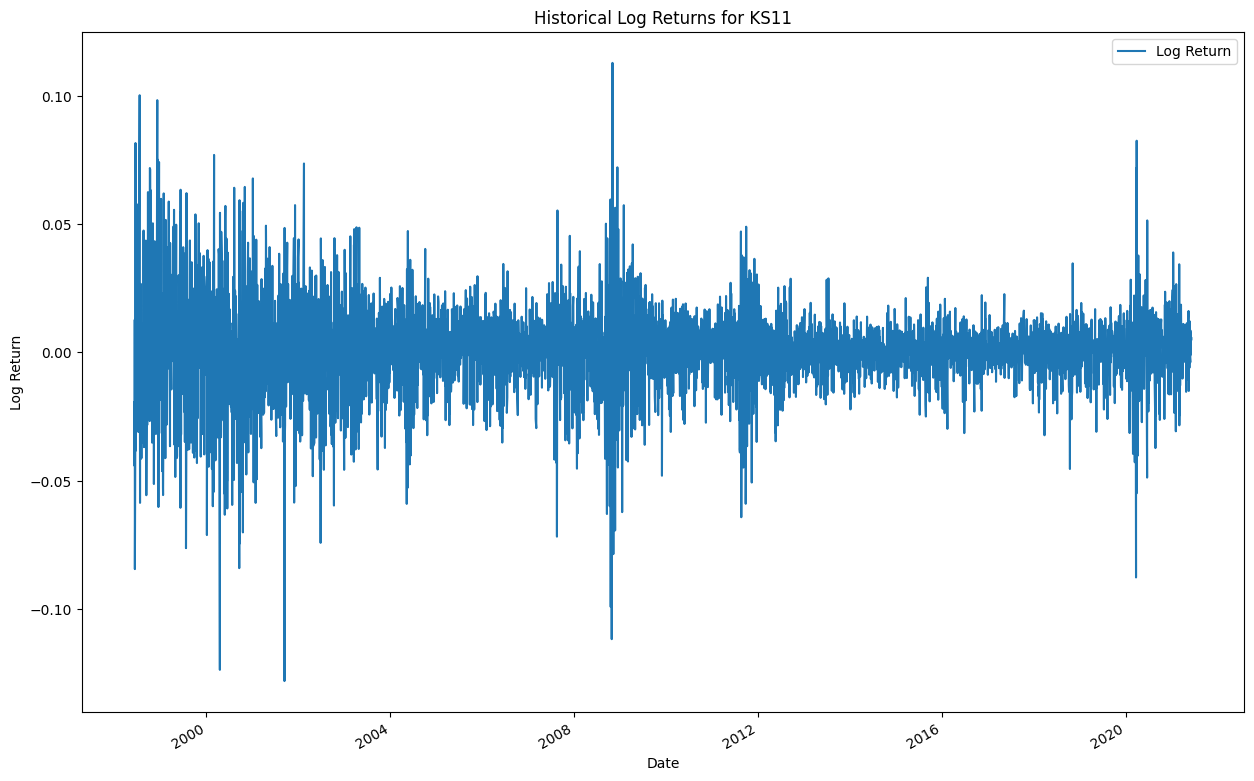

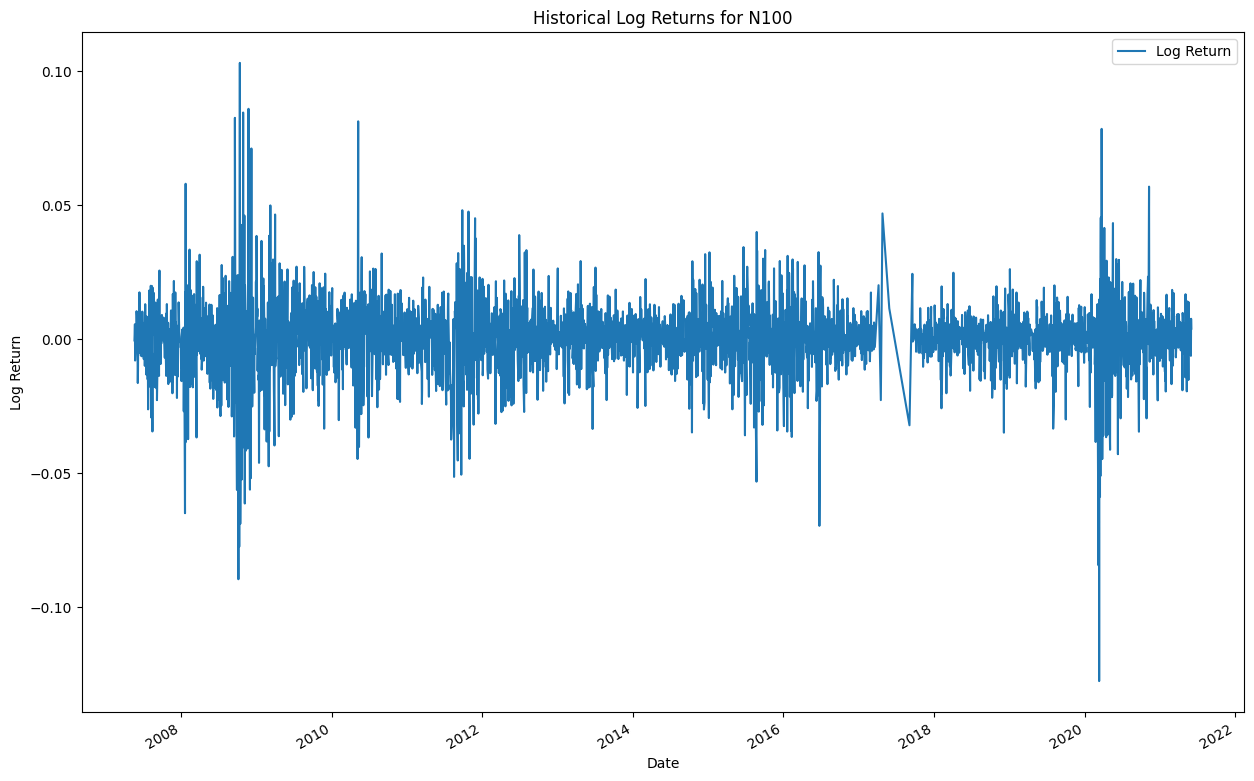

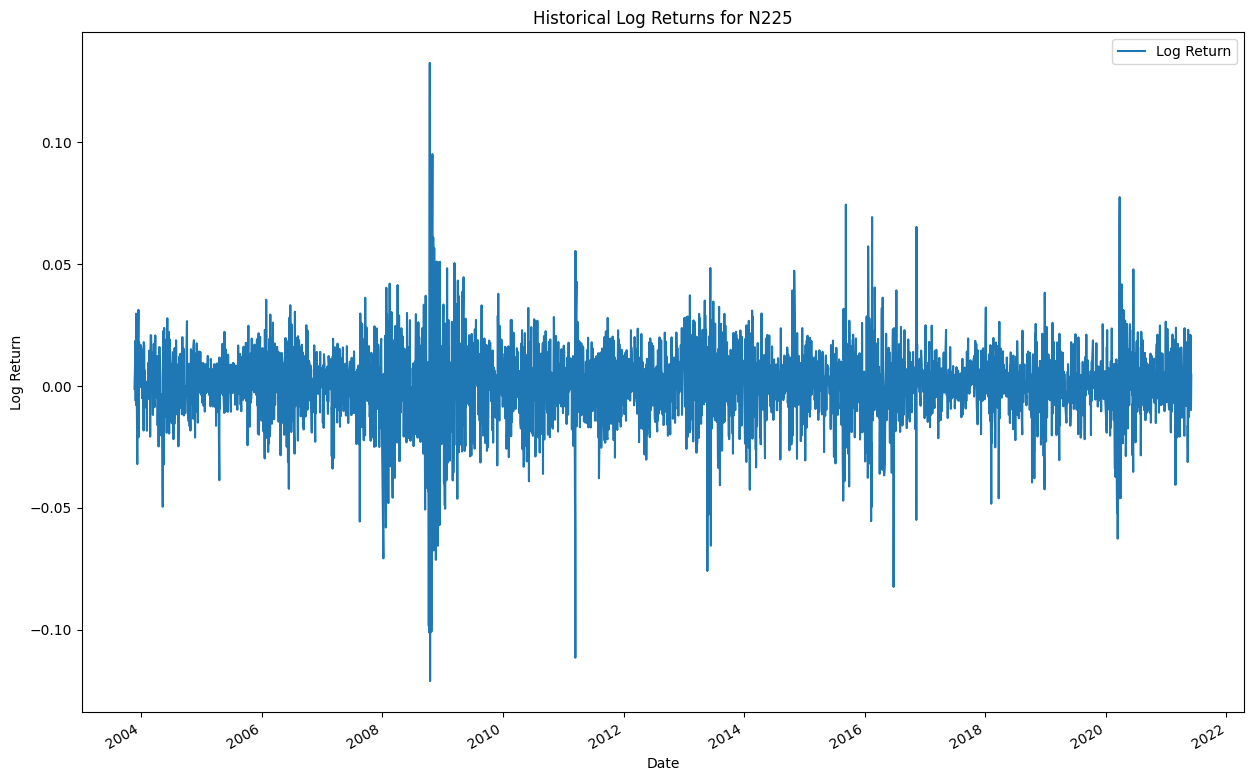

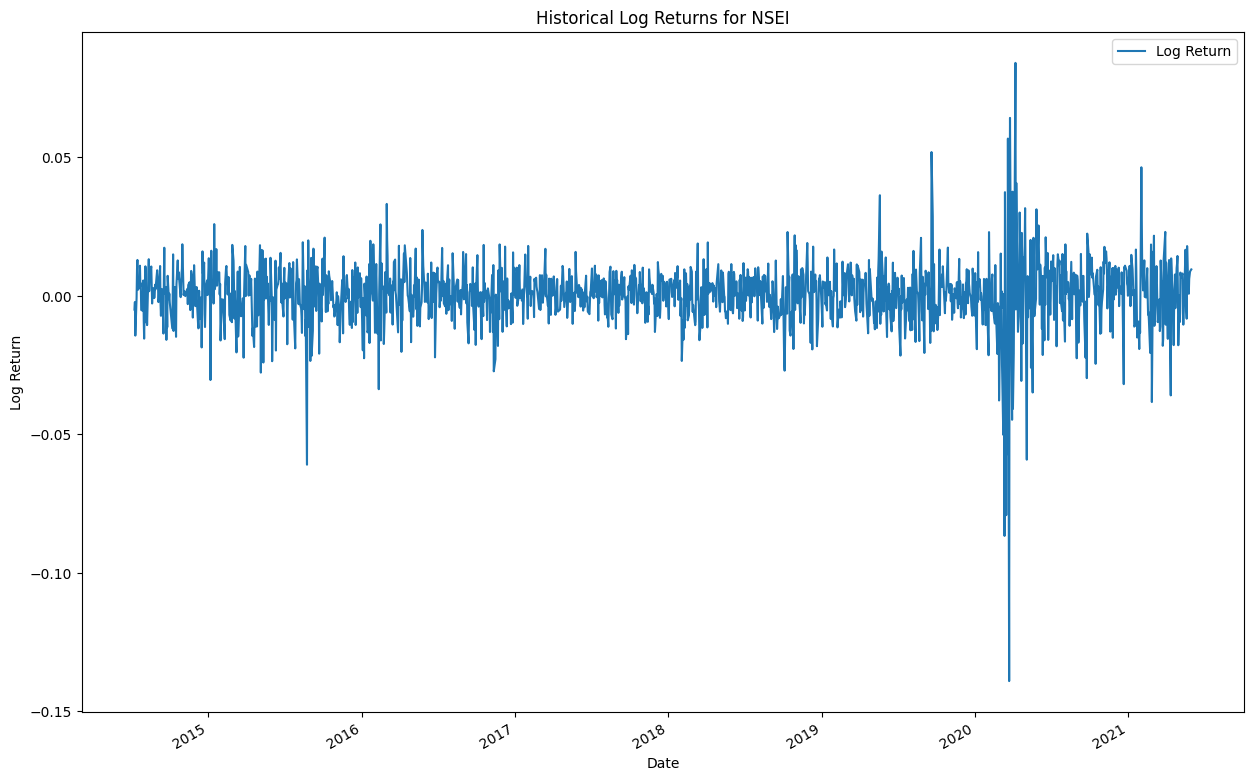

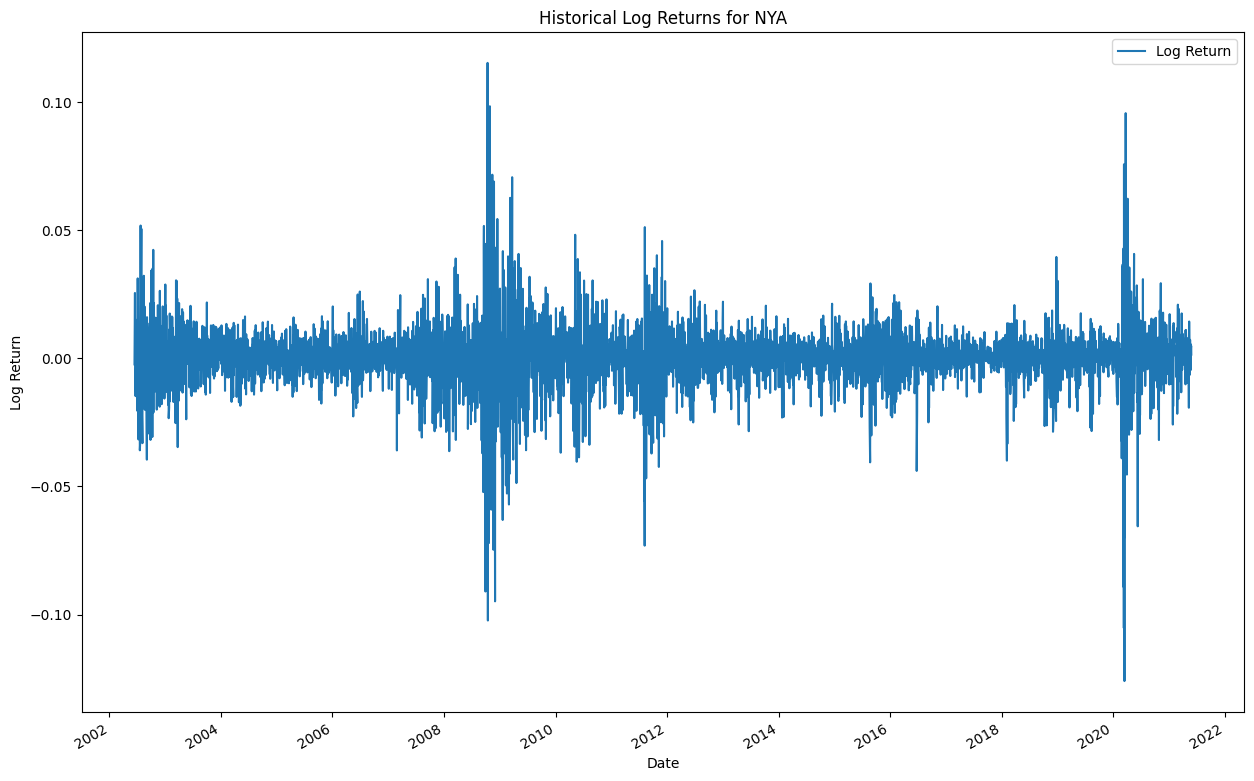

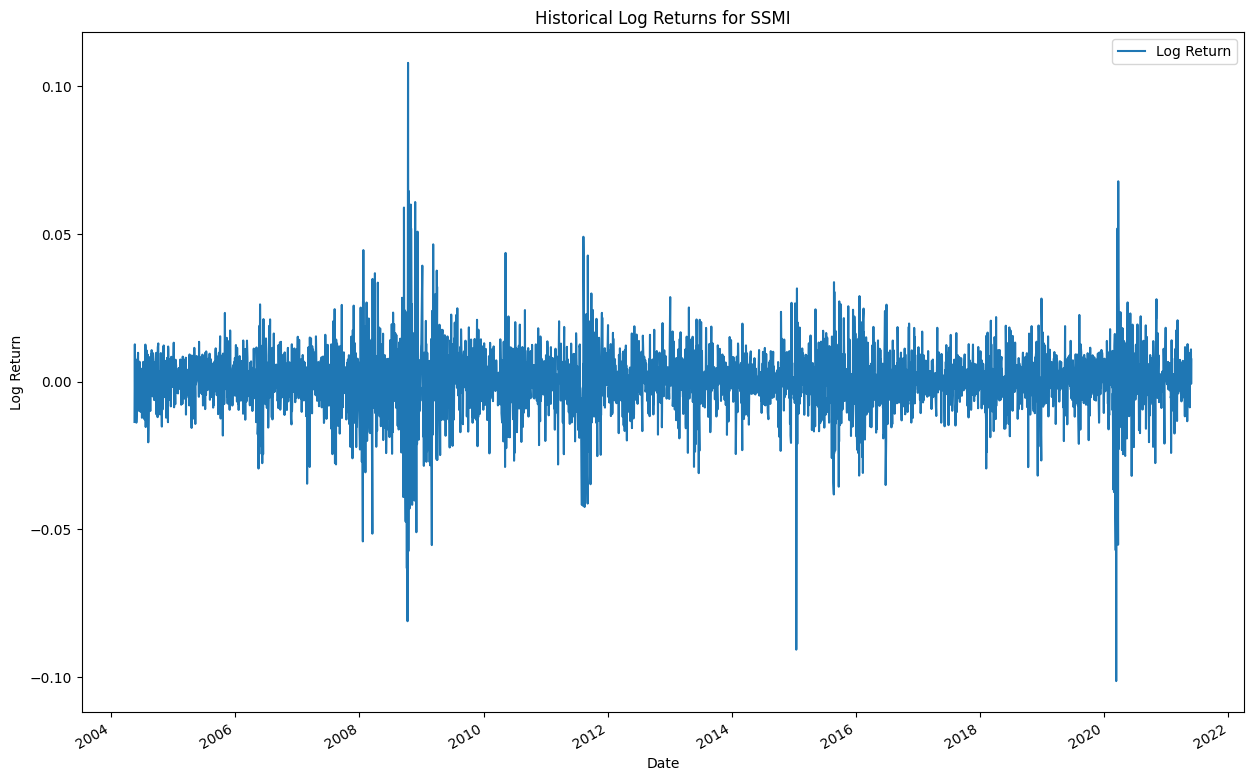

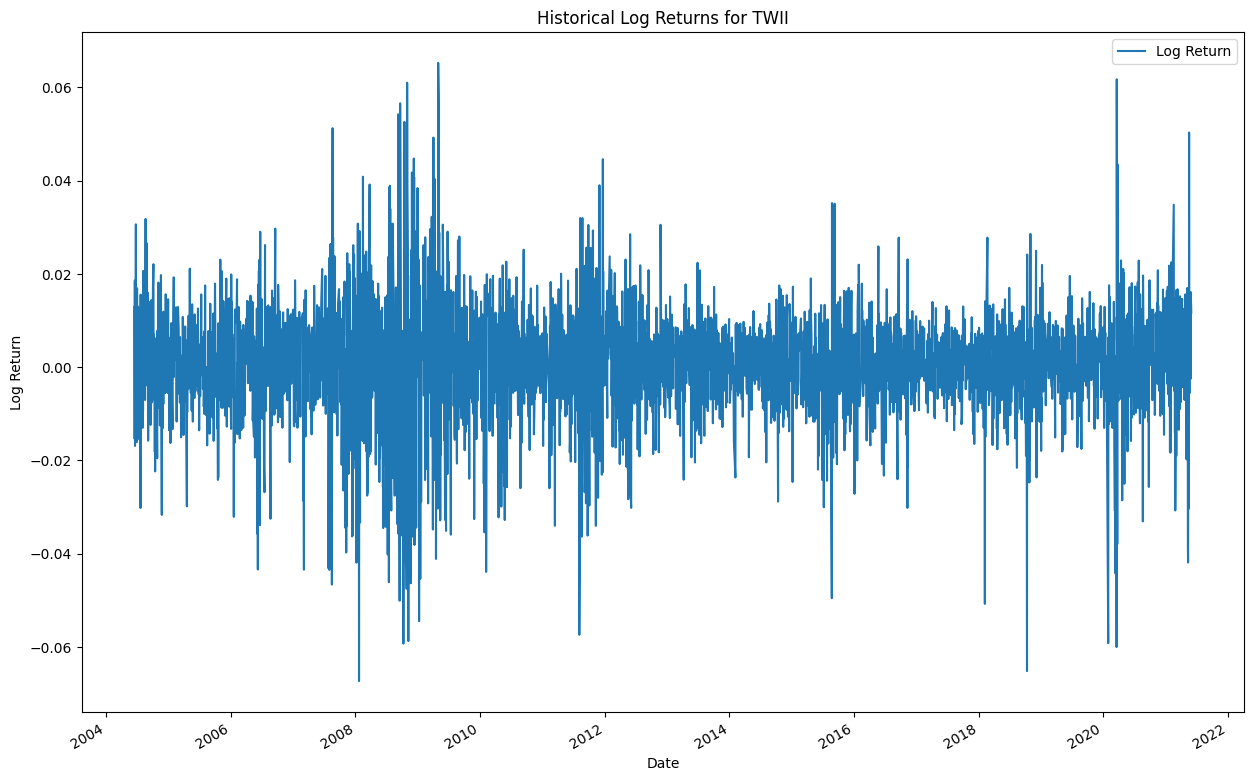

In [272]:
# Calculate log returns for each index.
for index in data_frames_per_index.keys():
    data_frames_per_index[index]["Log Return"] = np.log(
        data_frames_per_index[index]["Adj Close"]
        / data_frames_per_index[index]["Adj Close"].shift(1)
    )

# Generate a time series graph for each index.
for index in data_frames_per_index.keys():
    data_frames_per_index[index].plot(
        x="Date",
        y=[
            "Log Return",
        ],
        xlabel="Date",
        ylabel="Log Return",
        title=f"Historical Log Returns for {index}",
        figsize=(15, 10),
    )
